## <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

### Постановка задачи<a class="anchor" id="course_project_task"></a>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

### Примерное описание этапов выполнения курсового проекта<a class="anchor" id="course_project_steps"></a>

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

### Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [1]:
import numpy as np
import pandas as pd
import pickle
import random
from scipy import stats
from scipy.stats import shapiro, normaltest, ttest_rel, ttest_ind, kstest
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from scipy.stats.mstats import winsorize
from statsmodels.stats.weightstats import zconfint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, RandomizedSearchCV, ShuffleSplit, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn import ensemble
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from catboost import Pool,cv

import pprint
from termcolor import colored
from  more_itertools import unique_everseen

import warnings
warnings.simplefilter('ignore')

**Пути к директориям и файлам**

In [2]:
#input
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

# output
PREP_TRAIN_DATASET_PATH = 'course_project_train_prep.csv'
PREP_TEST_DATASET_PATH = 'course_project_test_prep.csv'

**Загрузка данных**

In [3]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [4]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [5]:
TARGET_COLUMN = 'Credit Default'

In [6]:
class CleanData:
    """Анализ и очистка датасета перед построением модели"""
    
    def __init__(self, df, target_column, name_df):
        self.X = df
        self.target_column = target_column
        self.name_df = name_df
        if  self.target_column:
            self.base_feature_names = self.X.columns.drop(self.target_column).tolist()
        else:
            self.base_feature_names  = self.X.columns
        self.medians=None
        self.missed_features = []
        self.full_features = []
        self.low_inf_features = []
        self.features_with_equel_math_ecpectation = []
        self.features_with_NO_equel_math_ecpectation = []
        self.features_for_join = []
        
    def overview(self):
        # shape and data types of the data
        print(f'\033[1mОбзор датасета на {self.name_df}\033[0m\n')
        X = self.X.copy()
        print(f'Объектов(строк): {X.shape[0]}, Признаков(столбцов): {self.X.shape[1]} \n')
        print(f'Список типов признаков: \n{X.dtypes}\n')
    def numeric_cols(self):
        # отбор числовых колонок
        print('\033[1mОбзор числовых признаков\033[0m\n')
        X = self.X.copy()
        df_numeric = X.select_dtypes(include=[np.number]).drop(self.target_column, axis = 1)
        numeric_cols = df_numeric.columns.tolist()
        print(numeric_cols, '\n')
        return numeric_cols

    def non_numeric_cols(self):
        # отбор нечисловых колонок
        print('\033[1mОбзор не числовых признаков\033[0m\n')
        X = self.X.copy()
        df_non_numeric = X.select_dtypes(exclude=[np.number])
        non_numeric_cols = df_non_numeric.columns.tolist()
        print(non_numeric_cols, '\n')
        return non_numeric_cols
    
    def hidden_cat_features(self, n_cat = 7):
        print(f'\033[1mПоиск скрытых категориальных признаков на {self.name_df}\033[0m\n')
        '''
        критерии отбора:
        - целые числа,
        - величина не превышает n_cat
        '''
        X = self.X.copy()
        df_cat_features = X.select_dtypes(include=['int64', 'int32'])
        if self.target_column in df_cat_features.columns:
            df_cat_features.drop(TARGET_COLUMN, axis=1, inplace=True)
        hidden_cat_cols = df_cat_features.max().loc[lambda x: x < n_cat].index
        if len(hidden_cat_cols) > 0:
            print(f'Данные признаки вероятно имеют категорийную природу: \n{list(hidden_cat_cols)}\n')
        else:
            print('Скрытых категориальных признаков не выявлено\n')
        return list(hidden_cat_cols)
    
    def hidden_bolean_features(self):
        print(f'\033[1mПоиск скрытых булевых признаков на {self.name_df}\033[0m\n')
        '''
        критерии отбора:
        - количество видов значений не превышает 2
        '''
        X = self.X.copy()
        df_cat_features = X #.select_dtypes(include='object')
        if self.target_column in df_cat_features.columns:
            df_cat_features.drop(TARGET_COLUMN, axis=1, inplace=True)
        hidden_bolean_cols = [] #df_cat_features.max().loc[lambda x: x <= 2].index
        for f in df_cat_features.columns:
            count_val = df_cat_features[f].value_counts()
            if len(count_val) < 3:
                hidden_bolean_cols.append([f, count_val])
                print(f'Признак {f} со значениями: \n{pd.DataFrame(count_val)}\n')
    
    def out_cat_range(self, criteria: dict):
        '''Проверка на выход за диапазоны справочных значений, если такие есть в описании датасета
        На вход подается словарь со значением справочников'''
        print('\033[1mПоиск ошибок в категриальных значениях\033[0m\n')
        X = self.X.copy()
        check_errors = []
        for key in criteria:
            n_err = df.loc[~X[key].isin(criteria[key])][key].count()
            if n_err>0:
                check_errors.append([key, n_err])

        print(f'Данные признаки имеют ошибки \n: {check_errors}\n')
        return check_errors
        
    def out_sigma(self, n_sigma = 5):
        '''
        - поиск выбросов по критерию n-sigma
        '''
        print(f'\033[1mПоиск выбросов на {self.name_df} по критерию {n_sigma} sigma:\033[0m\n')
        # vv = xx[~(np.abs(stats.zscore(xx.PAY_AMT2)) < 3).all(axis=1)].count()
        X = self.X.copy()
        out_of_range = []
        df_num_features = list(X.select_dtypes(include=['float64', 'float32']).columns )
        for x in df_num_features:
            condition = (~(np.abs(X[x]-X[x].mean()) <= (n_sigma*X[x].std())))
            oor = X.loc[condition, x]
            out_of_range.append({x: X.loc[condition, x].index})
            if oor.count() > 0:
                print(f'признак {x} имеет {oor.count()} выбросов\n')
        X[df_num_features].hist(figsize=(15, 15), bins=20, grid=False) 
        
    def outliers_fix(self, n_sigma = 5):
        '''
        - исправление выбросов по критерию n-sigma
        '''
        print(f'\033[1mИсправление выбросов на {self.name_df} по критерию {n_sigma} sigma:\033[0m\n')
        X = self.X.copy()
#         cat_gap_features = list(X[self.missed_features].select_dtypes(include=['float64', 'float32']).columns)
        df_num_features = list(X.select_dtypes(include=['float64', 'float32']).columns)
        for x in df_num_features:
            condition = (~(np.abs(X[x]-X[x].mean()) <= (n_sigma*X[x].std())))
            X.loc[condition, x] = 77777 #X[x].mean()    
        self.X = X 
    
    def find_missed_value(self):
        print(f'\033[1mАнализ пропусков на {self.name_df} \033[0m\n')
        X = self.X.copy()
        '''Анализ пропусков'''
        cols = X.columns

        missed = list(X.isna().sum().loc[lambda x: x > 0].index)
        if len(missed) != 0:
            print(f'Следующие признаки иимеют пропуски:\n')
            for m in missed:
                percent = round(100 * X[m].isnull().sum()/X.shape[0], 2)
                print(m, ': ', percent, '%\n')
            plt.figure(figsize=(20, 8))
            sns.heatmap(X[cols].isnull(), cmap=sns.color_palette(['b', 'r'] ))
            plt.title(f'Анализ пропусков на {self.name_df}')
            plt.show()
        else:
             print(f'Пропусков нет\n')
        print(missed)
        self.missed_features = missed
        self.full_features = list(X.isna().sum().loc[lambda x: x == 0].index)
    
    
    def low_information_feature(self):
        print(f'\033[1mПоиск малоинформативных признаков на {self.name_df} \033[0m\n')
        X = self.X.copy()
        num_rows = len(X.index)
        low_information_cols = [] #

        for col in X.columns:
            cnts = X[col].value_counts(dropna=False)
            top_pct = (cnts/num_rows).iloc[0]
            if top_pct > 0.95:
                low_information_cols.append(col)
                print('{0}: {1:.5f}%'.format(col, top_pct*100))
                print(cnts)
        self.low_inf_features = low_information_cols
    
    def find_dublicate(self):
        print(f'\033[1mПоиск дубликатов на {self.name_df} \033[0m\n')
        X = self.X.copy()
        cols = X.columns
        dbl = X[X[cols].duplicated()]
        if dbl.shape[0]>0:
            print(f'Найдено {dbl.shape[0]} дубликатов\n')
        else:
            print(f'Дубликаты не найдены\n')
    
    def find_diff_formats(self):
        '''Для поиска одинаковых значений категорийных признаков с разными форматами написания'''
        print(f'\033[1mПоиск одинаковых категориальных значений на {self.name_df}\033[0m\n')
        X = self.X.copy()
        cat_features = X.select_dtypes(include='object').columns
        list_cat_values = []
        for col in cat_features:
#             list_cat_values.append(pd.DataFrame(X[col].value_counts()))
            print(f'Категориальный признак: {pd.DataFrame(X[col].value_counts())}\n')
        
    def cat_сorr_value(self, corr_cat):
        '''функция для корректировки ошибок в категориальных признаках, 
        например дублирования одного и тогоже значения разными словами
        corr_cat[[l1],[l2],...] - список вложенных списков которые строится так:
        l[0] - наименование признака
        l[1] - значение признака которое подлежит изменению
        l[2] - значение признака на которое нужно изменить'''
        X = self.X.copy()
        for l in corr_cat:
            X.loc[X[l[0]]==l[1], l[0]] = l[2]
        self.X = X
    def to_boolian(self,to_bool_list):
        '''функция для приведения признаков к булевому типу
        to_bool_list[[l1],[l2],...] - список вложенных списков которые строится так:
        l[0] - наименование признака
        l[1] - значение признака которое нужно установить в 0
        l[2] - значение признака которое нужно установить в 1
        '''
        X = self.X.copy()
        for l in to_bool_list:
            X.loc[X[l[0]]==l[1], l[0]] = 0
            X.loc[X[l[0]]==l[2], l[0]] = 1
        self.X = X
        
        
    def predict_missed_value(self, features_with_gaps: list, gap_cutoff = 0.5):
        '''Функция для заполнения отсутствующих данных
        Для численных признаков применена методика регресии с использованием имеющихся в датасете признаков
        Для категориальных признаков отсутствующие значения устанавливаются в "999"'''
        # Те признаки, которые имеют пропусков более чем gap_cutoff, будут удалены'''
        
        
        if len(features_with_gaps) > 0:
            
            print(f'Следующие признаки иимеют пропуски:\n')
            
#             for m in range(len(features_with_gaps)-1):
#                 if self.X[features_with_gaps[m]].isnull().sum()/self.X.shape[0] > gap_cutoff:
#                     print(f'...Найден признак "{features_with_gaps[m]}", у которого пробусков более {gap_cutoff*100}%, удаляем его')
#                     self.X = self.X.drop(features_with_gaps[m],axis=1)
#                     features_with_gaps.pop(m)
                
            full = self.X.isna().sum().loc[lambda x: x == 0].index # признаки без гапов
            f_num = self.X[features_with_gaps].select_dtypes(include=[np.number]).columns # признаки с гапами только численные
            for f in f_num:
                X = self.X[full].select_dtypes(include=[np.number])
                y = self.X[f].copy()
                idx_pred = np.where(y.isna()==True)[0]
                X_pred = np.array(X.iloc[idx_pred])

                idx_fix = np.where(y.isna() == False)[0]
                X_filled= np.array(X.iloc[idx_fix])
                y_filled= np.array(y.iloc[idx_fix])

                model1 = ensemble.GradientBoostingRegressor()
                model2 = RandomForestRegressor()
                model3 = LGBMRegressor()
                model4 = LinearRegression()

                model = VotingRegressor([('model1', model1), ('model2', model2), ('model3', model3), ('model4', model4)])

#                 X_train, X_test, y_train, y_test = train_test_split(X_filled, y_filled, test_size=0.3)

                cv_score = cross_val_score(model, X_filled, y_filled, 
                                       scoring='r2', 
                                       cv=KFold(n_splits=5, shuffle=True, random_state=42))
                # cv_score
                mean = cv_score.mean()
                std = cv_score.std()


                print('...признак "{:} на {:}" - (R2: {:.3f} +- {:.3f}), ----заполнен'.format(f, self.name_df, mean, std))

                model.fit(X_filled, y_filled)

                # заполняем признак
                self.X[f].values[idx_pred] = model.predict(X_pred)

            f_not_num = self.X[features_with_gaps].select_dtypes(exclude=[np.number]).columns # признаки с гапами только категориальные
            for nf in f_not_num:
                self.X.loc[self.X[nf].isna(), nf]  = '999'
        else:
            print('Список features_with_gaps пуст')
        # Проверка
        missed = list(self.X.isna().sum().loc[lambda x: x > 0].index)
        if len(missed) == 0:
            print ('Все признаки заполнены успешно')
            return True
        else:
            print (f'Есть еще признаки с пробелами: {missed}')
            return False
        
        
    def drop_feature(self, features): 
        self.X = self.X.drop(features,axis=1)
        try:
            self.missed_features.pop(self.missed_features.index(features))
        except Exception:
            print(Exception)
        
    def create_ID_feature(self):
        self.X['ID'] = self.X.index.tolist()
        
    def create_dummy(self):
        D = pd.get_dummies(self.X[self.X.select_dtypes(exclude=[np.number]).columns])
        self.X = pd.concat([self.X, D], axis=1)
        
    
    def corr_base_target(self):
        print(f'\033[1mCмотрим распределение целевой переменной на {self.name_df}\033[0m\n')
        # смотрим распределение целевой переменной
        X = self.X.copy()
        X[self.target_column].value_counts()
        # посмотрим графически
        plt.figure(figsize=(8, 5))
        sns.countplot(x=self.target_column, data=X)
        plt.title('Target variable distribution')
        plt.show()
        print(f'\033[1mКореляция признаков с таргетом на {self.name_df}\033[0m\n')
        corr_with_target = self.X.corr().iloc[:-1, -1].sort_values(ascending=False)
        plt.figure(figsize=(10, 8))
        sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
        plt.title(f'Correlation with target variable: {self.target_column}')
        plt.show()
        
    def cat_featere_target_estimate(self, alpha = 0.05):
        s = "\033[1mГипотеза\033[0m\
            \n - Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы\
            \n - Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы\
            \n - Критерий: Хи-квадрат Пирсона\
            \n - Уровень значимости  𝛼 - 0.05\
            \n - Критическая область: двухсторонняя\
            \nДля проверки данной гипотезы необходимо подать наблюдаемые частоты категорий исследуемого признака в выбранный критерий,\
            \nпосле чего оценить значение достигаемого уровня значимости p-value и сравнить с его с выбранным порогом альфа, \
            \nесли p-value получится больше выбранного порога, то гипотезу о согласованности частот можно не отбрасывать"
        print(s)
        X = self.X.copy()
        cat_feature = X.select_dtypes(exclude=[np.number]).columns
        target = self.target_column

        
        for_join = []

        for col in cat_feature:
            list_values = list(X[col].value_counts().index)
            plt.figure(figsize=(20, 8))
            sns.countplot(x=col, hue=target, data=X)
            plt.title(f'"{col}" grouped by target variable')
            plt.legend(title='Target', loc='upper right')
            plt.show()
            
            similar_features = []
            for i in range(len(list_values)):
#                 print(list_values)
                same = []
                if len(list_values) > 1:
                    same.append(list_values[i])
                    for j in range(len(list_values)):
                        if i!=j:
                            #Сформируем выборку и рассчитаем наблюдаемые частоты
                            feature_and_target = X.loc[X[col].isin([list_values[i], list_values[j]]), ['ID', col, target]]
                            table = feature_and_target.pivot_table(values='ID', index=col, columns=target, aggfunc='count')
                            # Проверим нашу гипотезу используя критерий Хи-квадрат Пирсона
                            if len(table) > 0:
                                chi2, p, dof, expected = chi2_contingency(table, correction=False)
                                if p > alpha:
                                    same.append(list_values[j])
                                    same.sort()
                                
                    
                else:
                    break
                
                if len(same)>1:
                    similar_features.append([col, same])
                
            print('Следующие значения категорияльных признаков можно объединить')
            print(list(unique_everseen(similar_features)))  
                
            self.features_for_join.append(list(unique_everseen(similar_features)))

    
    
    def num_featere_target_estimate(self, alpha = 0.05):
        
        s = "\033[1mГипотеза\033[0m\
            \n - Нулевая гипотеза: Нулевая гипотеза: средние значения в двух независимых выборках равны\
            \n - Альтернативная гипотеза: средние значения в двух независимых выборках различаются\
            \n - Критерий: критерий Стьюдента (t-тест) и его аналоги\
            \n - Уровень значимости  𝛼 - 0.05\
            \n - Критическая область: двухсторонняя\
            \nЧто бы проверить данную гипотезу сравним две выборки из рассматриваемых групп на предмет\
            \nравенства средних значений. Если вероятность того, что мат. ожидания в исходных группах равны,\
            \nпри данных выборках, буде менее 5%, то можно будет говорить о том,\
            \nчто скорее всего выборки имеют различные распределения."

        print(s)
        X = self.X.copy()
        num_feature = X.select_dtypes(include=[np.number]).columns.drop(self.target_column).tolist()
        target = self.target_column

        
        for f in num_feature:
            #Оценка признаков в разрезе целевой переменной
            
            print(f'\033[1mОценка признака "{f}" в разрезе целевой переменной "{target}"\033[0m\n')
            
            
            feature_with_target = X[[f, target]].sample(1000)
            feature_s = feature_with_target[f]
            feature_target_0 = feature_s[feature_with_target[target] == 0]
            feature_target_1 = feature_s[feature_with_target[target] == 1]
            
            features_with_equel_math_ecpectation = []
            features_with_NO_equel_math_ecpectation = []

            self.kde_plot_feature_target(feature_target_0, feature_target_1, f)
            
            #Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка
            statistic, pvalue = shapiro(feature_s)
            if pvalue < alpha:
                print(f' p_value = {pvalue}, меньше alpha = {alpha} - гипотеза о "нормальности" \033[1mотвергается\033[0m.\n')
                print('Для достоверности произведём визуальную оценку распределения признака')
                self.qqplot_features(f, feature_s)
                print('Попробуем проверить признак на нормальность после его стандартизирования')
                feature_log=np.log(feature_s)/np.log(2)
                statistic, pvalue = shapiro(feature_log)
                print(f'статистика = {statistic}, p_value = {pvalue}\n')
                if (pvalue > 0 or pvalue != 1.0) and (statistic > 0 or ~np.isnan(statistic)):
                    self.qqplot_features(f, feature_log)
                    if pvalue < alpha:
                        print(f' p_value = {pvalue}, меньше alpha = {alpha} - гипотеза о "нормальности" \033[1mотвергается\033[0m.\n')
                        
                        s = f'Визуальная оценка подтверждает показания критерия Шапиро-Уилка:\
                        \nчто закон распределения отличный от "нормального" поэтому мы не сможем воспользоваться критерием\
                        \nСтьюдента для проверки гипотезы о равности мат. ожиданий признака {f}, но мы сможем воспользоваться его непараметрическим\
                        \nаналогом - критерием Манна-Уитни, который не требователен к закону распределения\n'
                        print(s)
                        
                        equel_me = self.equal_check_math_expect(f, feature_with_target, feature_target_0, feature_target_1, distribution = 'abnorm')
                        if equel_me:
                            self.features_with_equel_math_ecpectation.append(f)
                        else: 
                            self.features_with_NO_equel_math_ecpectation.append(f)
                    else:
                        print(f' p_value = {pvalue}, меньше alpha = {alpha} - гипотеза о "нормальности" \033[1mпринимается\033[0m.\n')
                        equel_me = self.equal_check_math_expect(f, feature_with_target, feature_target_0, feature_target_1, distribution = 'norm')
                        if equel_me:
                            self.features_with_equel_math_ecpectation.append(f)
                        else: 
                            self.features_with_NO_equel_math_ecpectation.append(f)
                else: 
                    print(f'Признак {f} невозможно корректно стандратизировать, делаем окончательный вывод о том,\
                    \nчто его \033[1mраспределение неноромально\033[0m\n')
                    equel_me = self.equal_check_math_expect(f, feature_with_target, feature_target_0, feature_target_1, distribution = 'abnorm')
                    if equel_me:
                        self.features_with_equel_math_ecpectation.append(f)
                    else: 
                        self.features_with_NO_equel_math_ecpectation.append(f)
            else:
                print(f' p_value = {pvalue}, меньше alpha = {alpha} - гипотеза о "нормальности" \033[1mпринимается\033[0m.\n')
                equel_me = self.equal_check_math_expect(f, feature_with_target, feature_target_0, feature_target_1, distribution = 'norm')
                if equel_me:
                    self.features_with_equel_math_ecpectation.append(f)
                else: 
                    self.features_with_NO_equel_math_ecpectation.append(f)
                
                
                
    def kde_plot_feature_target(self, feature_target_0, feature_target_1, feature):
        plt.figure(figsize=(10, 5))
        sns.kdeplot(feature_target_0, shade=True, label='No default', color='g')
        sns.kdeplot(feature_target_1, shade=True, label='Default', color='r')
        plt.xlabel(feature)
        plt.title(f'{feature} grouped by target variable')
        plt.show()
        
    def qqplot_features(self, feature, df_feature):
        plt.figure(figsize=(20, 8))
        ax1 = plt.subplot(121)
        ax1.set_xlabel(feature)
        ax1.set_ylabel('Count')
        ax1.set_title(f'"{feature}" distribution')
        df_feature.hist()
        plt.subplot(122)
        probplot(df_feature, dist='norm', plot=plt)
        plt.show()
        
    def confidens_intervals_plot(self, feature, feature_with_target):
        plt.figure(figsize=(8, 5))
        sns.pointplot(x=self.target_column, y=feature, data=feature_with_target, capsize=.1)
        plt.title(f'Confidence intervals (95 %) for {feature}')
        plt.show()
    
    def equal_check_math_expect(self, feature, feature_with_target, feature_target_0, feature_target_1, distribution = 'norm', alpha = 0.05):
        pvalue = 0
        statistic = 0
        if distribution == 'norm' and len(feature_target_0) == len(feature_target_1):
            print('Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью теста Стьюдента\n')
            statistic, pvalue = ttest_rel(feature_target_0, feature_target_1)
        else:
            if len(feature_target_0) == len(feature_target_1):
                print('Тест Стьюдента не применим когда выборки не равны, поэтому используем критерия Манна-Уитни')
            print('Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни\n')
            statistic, pvalue = mannwhitneyu(feature_target_0, feature_target_1)
        
        if pvalue > 0:
            if pvalue < alpha:
                print(f'Согласно значению p-value {pvalue} , гипотеза о равности мат. ожиданий \033[1mотвергается\033[0m.,\
                \nно стоит ради дополнительной проверки обратиться к доверительным интервалам.\n')
                print('Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их\n')
                self.confidens_intervals_plot(feature, feature_with_target)
                return False
            else:
                print(f'Согласно значению p-value {pvalue} , гипотеза о равности мат. ожиданий \033[1mподтверждается\033[0m,\
                \nно стоит ради дополнительной проверки обратиться к доверительным интервалам.\n') 
                print('Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их\n')
                self.confidens_intervals_plot(feature, feature_with_target)
                return True
            
        else:
            print('Сравнить мат. ожидания не удалось по какой-то причине')
            return None
            
    def remove_outliers(self, limits = 0.01):
        X = self.X.copy()
        if self.target_column == None:
            num_feature = X.select_dtypes(include=[np.number]).columns
        else:
            num_feature = X.select_dtypes(include=[np.number]).columns.drop(self.target_column).tolist()
        for f in num_feature:
            self.X[f] = winsorize(X[f], limits)
    def corr_matrix(self):
        X = self.X.copy()
        num_feature = X.select_dtypes(include=[np.number]).columns.drop(self.target_column).tolist()
        plt.figure(figsize = (25,20))
        sns.set(font_scale=1.4)
        sns.heatmap(X[num_feature].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')
        plt.title('Correlation matrix')
        plt.show()

In [7]:
# создали объект класса СleanData
c_train = CleanData(df_train, TARGET_COLUMN, 'Train')
c_test = CleanData(df_test, None, 'Test')

In [8]:
# c_train.num_featere_target_estimate()

### Анализ датасета

In [9]:
# Обзор датасета
c_train.overview() 
c_test.overview() 

Обзор датасета на Train

Объектов(строк): 7500, Признаков(столбцов): 17 

Список типов признаков: 
Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

Обзор датасета на Test

Объектов(строк): 2500, Признаков(столбцов): 16 

Список типов признаков: 
Home Ownership                   object
Annual Income                   float64
Years in current job        

#### Поиск признаков, которые можно преобразовать в булевый тип

In [10]:
# Проверяем есть ли на трейне/тесте признаки у которых всего 2 значения
c_train.hidden_bolean_features()  
c_test.hidden_bolean_features() 

# Принято решение преобразовать признак "Term" к типу Bool на трейне и на тесте:
# Поэтому включаем в функцию очистки clean_data() данное действие

Поиск скрытых булевых признаков на Train

Признак Term со значениями: 
            Term
Short Term  5556
Long Term   1944

Поиск скрытых булевых признаков на Test

Признак Term со значениями: 
            Term
Short Term  1861
Long Term    639



#### Поиск категориальных признаков, дубликатов или ошибок в написании

In [11]:
c_train.find_diff_formats() 
c_test.find_diff_formats()

Поиск одинаковых категориальных значений на Train

Категориальный признак:                Home Ownership
Home Mortgage            3637
Rent                     3204
Own Home                  647
Have Mortgage              12

Категориальный признак:            Years in current job
10+ years                  2332
2 years                     705
3 years                     620
< 1 year                    563
5 years                     516
1 year                      504
4 years                     469
6 years                     426
7 years                     396
8 years                     339
9 years                     259

Категориальный признак:                       Purpose
debt consolidation       5944
other                     665
home improvements         412
business loan             129
buy a car                  96
medical bills              71
major purchase             40
take a trip                37
buy house                  34
small business             26
wedding    

**Что обнаружили:**
1. Судя по всему, признак "Home Ownership" имеет дубликаты в названиях его значений: "Home Mortgage" есть тоже самое что и "Have Mortgage"?

2. Признак "Purpose" имеет неповторяющихся в трейне и тесте значений. Вероятно, необходимо их стандартизировать и отсечь значения с малой частотой для недопущения переобучения модели на низкочастотных значениях признака

3. Все найденные значения признаков имеют пробелы, и возможно разное написание, что сложно отследить визуально 

**Что делаем:**
1. На основе признаков "Home Ownership", "Purpose", "Years in current job"  и  постороим новый справочник со стандартизированными значениями.
 Внесем эти действия в функцию clean_data()

#### Обработка пропусков

Анализ пропусков на Train 

Следующие признаки иимеют пропуски:

Annual Income :  20.76 %

Years in current job :  4.95 %

Months since last delinquent :  54.41 %

Bankruptcies :  0.19 %

Credit Score :  20.76 %



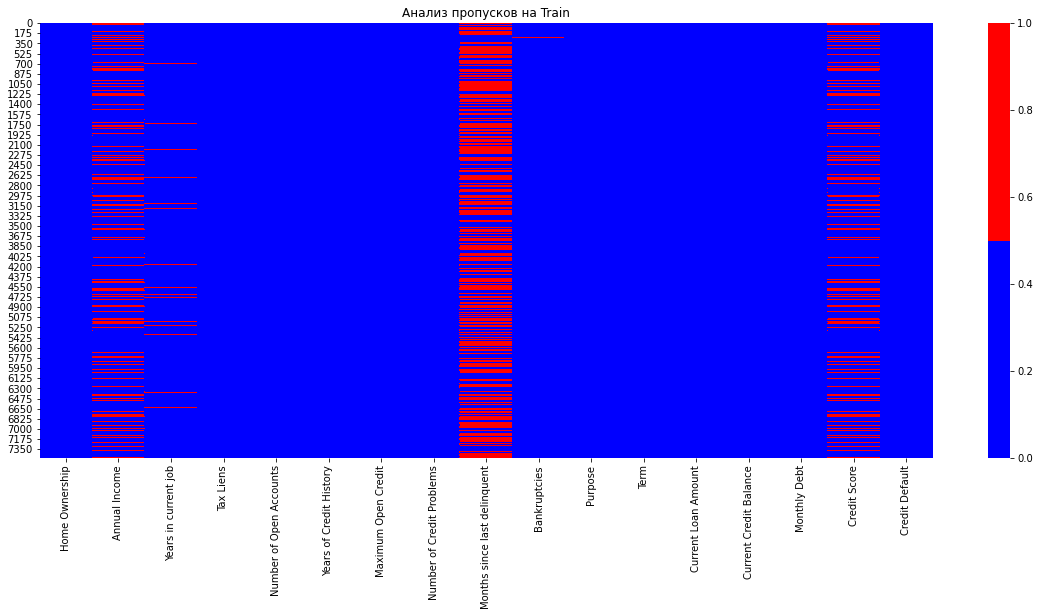

['Annual Income', 'Years in current job', 'Months since last delinquent', 'Bankruptcies', 'Credit Score']
Анализ пропусков на Test 

Следующие признаки иимеют пропуски:

Annual Income :  20.52 %

Years in current job :  3.44 %

Months since last delinquent :  54.32 %

Bankruptcies :  0.12 %

Credit Score :  20.52 %



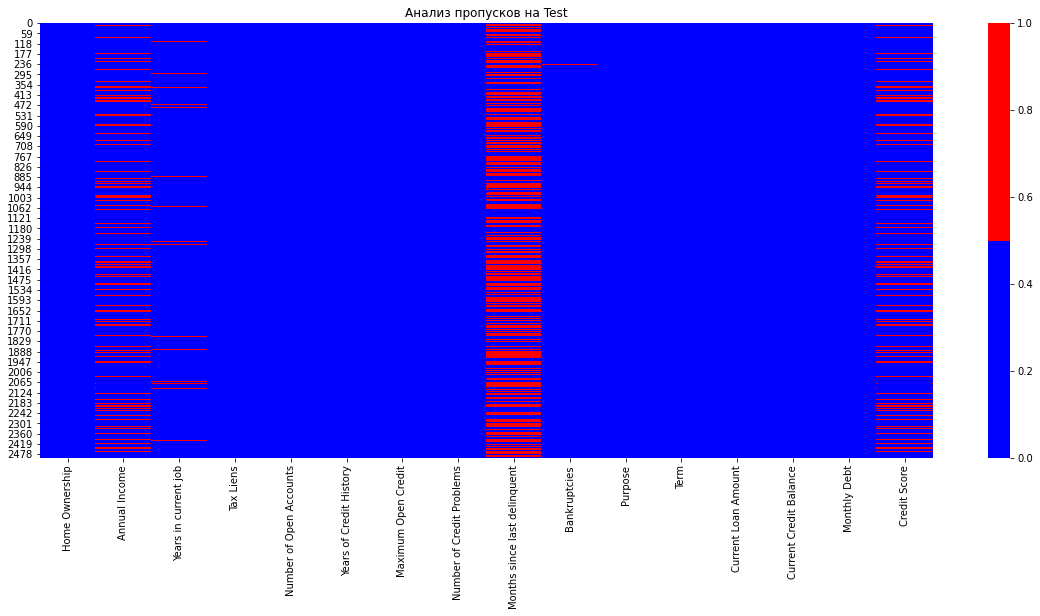

['Annual Income', 'Years in current job', 'Months since last delinquent', 'Bankruptcies', 'Credit Score']


In [12]:
c_train.find_missed_value()
c_test.find_missed_value()

Выявили что признак "Months since last delinquent"  имеет более  54 % пропусков, удаляем его. Добавим соответствующие действия в функцию clean_data()

**Что делаем:**
Попытаемся восстановить пропущенные значения с помощью функции восстановления по признакам не имеющим пропуски.
Добавим соответствующие действия в функцию clean_data(). Но сначала посмотрим есть ли среди них малоинформативные признаки. Если есть, то их можно будет просто удалить из датасета.

In [13]:
c_train.low_information_feature()
c_test.low_information_feature()

Поиск малоинформативных признаков на Train 

Tax Liens: 98.21333%
0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64
Поиск малоинформативных признаков на Test 

Tax Liens: 97.80000%
0.0     2445
1.0       45
2.0        5
15.0       1
3.0        1
6.0        1
4.0        1
5.0        1
Name: Tax Liens, dtype: int64


Вносим в функцию clean_data() действие по удалению признака "Liens"

#### Поиск скрытых категриальных признаков

In [14]:
c_train.hidden_cat_features(n_cat = 10)
c_test.hidden_cat_features(n_cat = 10)

Поиск скрытых категориальных признаков на Train

Скрытых категориальных признаков не выявлено

Поиск скрытых категориальных признаков на Test

Скрытых категориальных признаков не выявлено



[]

#### Поиск выборсов

Поиск выбросов на Train по критерию 3 sigma:

признак Annual Income имеет 98 выбросов

признак Tax Liens имеет 134 выбросов

признак Number of Open Accounts имеет 88 выбросов

признак Years of Credit History имеет 91 выбросов

признак Maximum Open Credit имеет 4 выбросов

признак Number of Credit Problems имеет 149 выбросов

признак Months since last delinquent имеет 1 выбросов

признак Bankruptcies имеет 40 выбросов

признак Current Credit Balance имеет 110 выбросов

признак Monthly Debt имеет 105 выбросов

признак Credit Score имеет 400 выбросов

Поиск выбросов на Test по критерию 3 sigma:

признак Annual Income имеет 26 выбросов

признак Tax Liens имеет 10 выбросов

признак Number of Open Accounts имеет 31 выбросов

признак Years of Credit History имеет 34 выбросов

признак Maximum Open Credit имеет 17 выбросов

признак Number of Credit Problems имеет 43 выбросов

признак Bankruptcies имеет 11 выбросов

признак Current Credit Balance имеет 32 выбросов

признак Monthly Debt имеет 35 

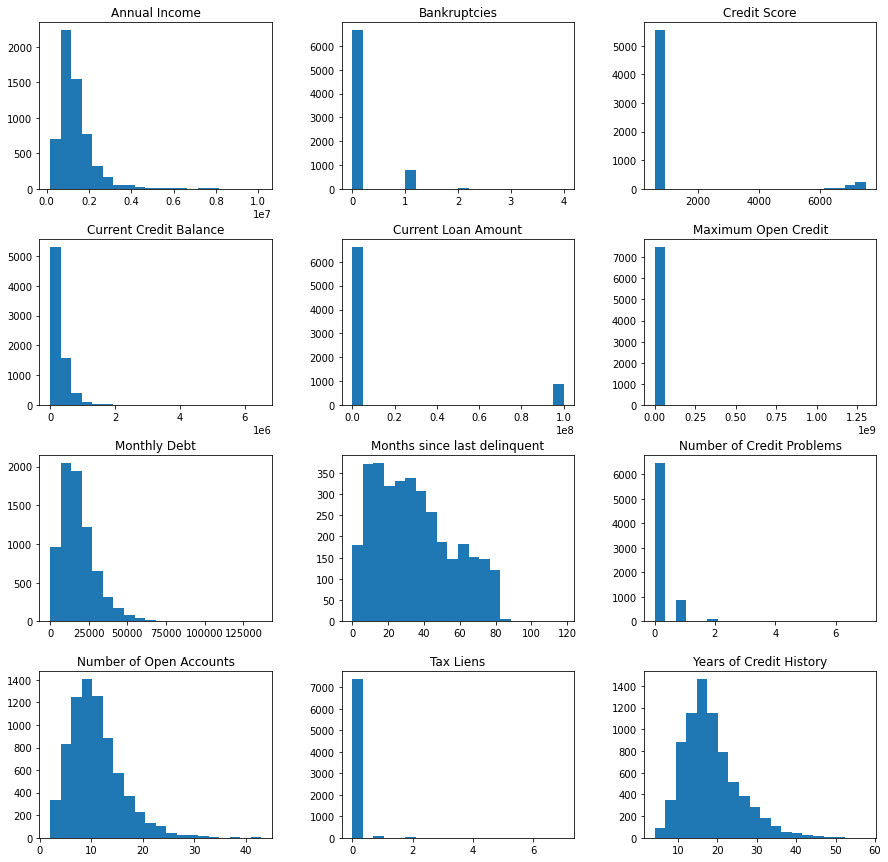

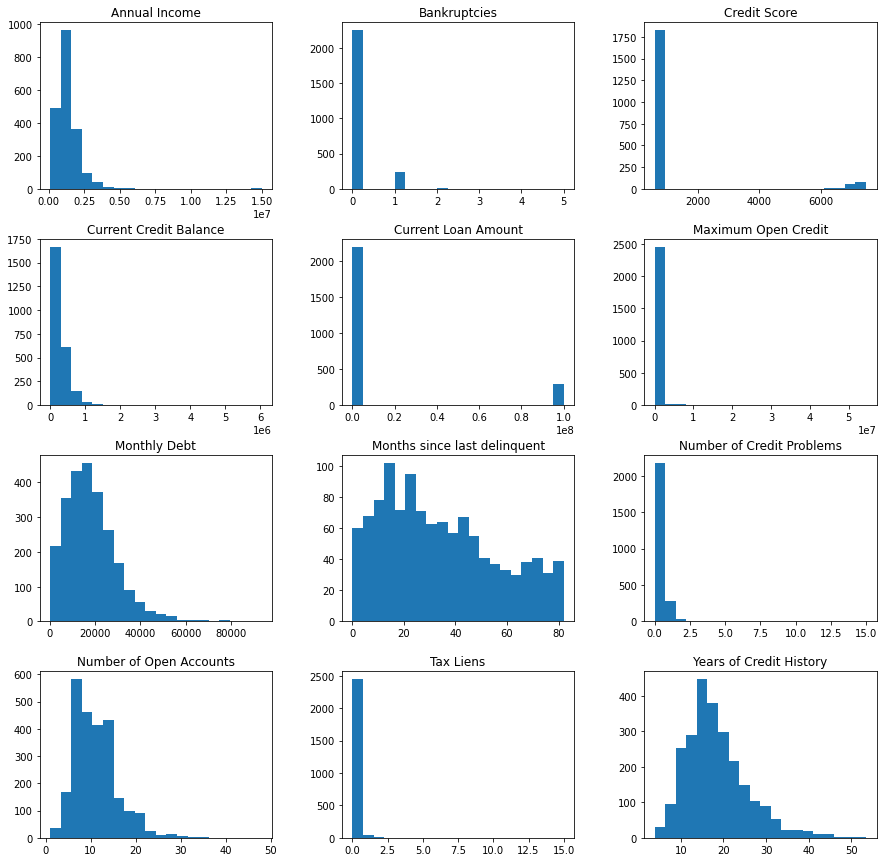

In [15]:
c_train.out_sigma(n_sigma = 3)
c_test.out_sigma(n_sigma = 3)

#### Очистим датасеты от выбросов

Добавим в функцию очистки clean_data()соответствующее действие

#### Проверим на дубликаты

In [16]:
c_train.find_dublicate()
c_test.find_dublicate()

Поиск дубликатов на Train 

Дубликаты не найдены

Поиск дубликатов на Test 

Дубликаты не найдены



#### Создадим новый признак 'ID' в функции clean_data()

добавим в функцию clean_data() соответствующее действие create_ID_feature()

#### Делаем предварительную очистку

...преобразуем признаки в булевы значения
...построим новый справочник со стандартизированными категриальными значениями
...скорректируем значения признаков в соответствии с новым справочником
...удаляем признак "Months since last delinquent"
...удаляем признак Tax Liens
<class 'Exception'>
<class 'Exception'>
...добавляем признак ID
...заполняем гапы в признаках
Следующие признаки иимеют пропуски:

...признак "Annual Income на Train" - (R2: 0.419 +- 0.042), ----заполнен
...признак "Bankruptcies на Train" - (R2: 0.694 +- 0.021), ----заполнен
...признак "Credit Score на Train" - (R2: 0.173 +- 0.036), ----заполнен
Все признаки заполнены успешно
Следующие признаки иимеют пропуски:

...признак "Annual Income на Test" - (R2: 0.288 +- 0.104), ----заполнен
...признак "Bankruptcies на Test" - (R2: 0.484 +- 0.154), ----заполнен
...признак "Credit Score на Test" - (R2: -0.026 +- 0.024), ----заполнен
Все признаки заполнены успешно
...удаляем выбросы
...проверяем еще раз на выбросы и сравниваем ка

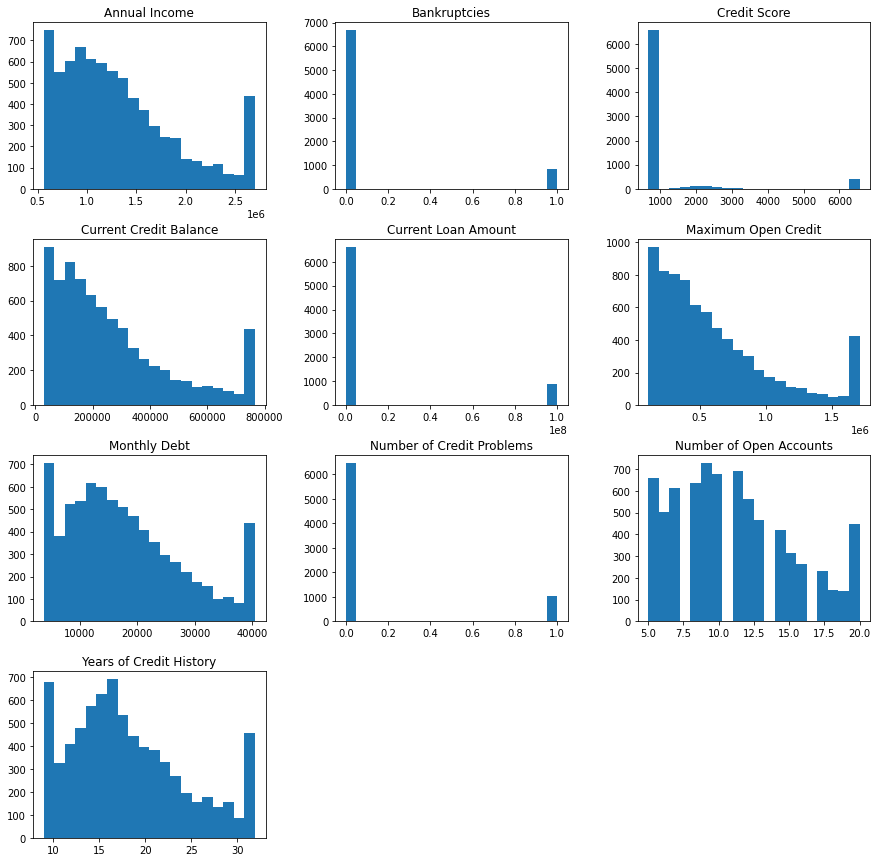

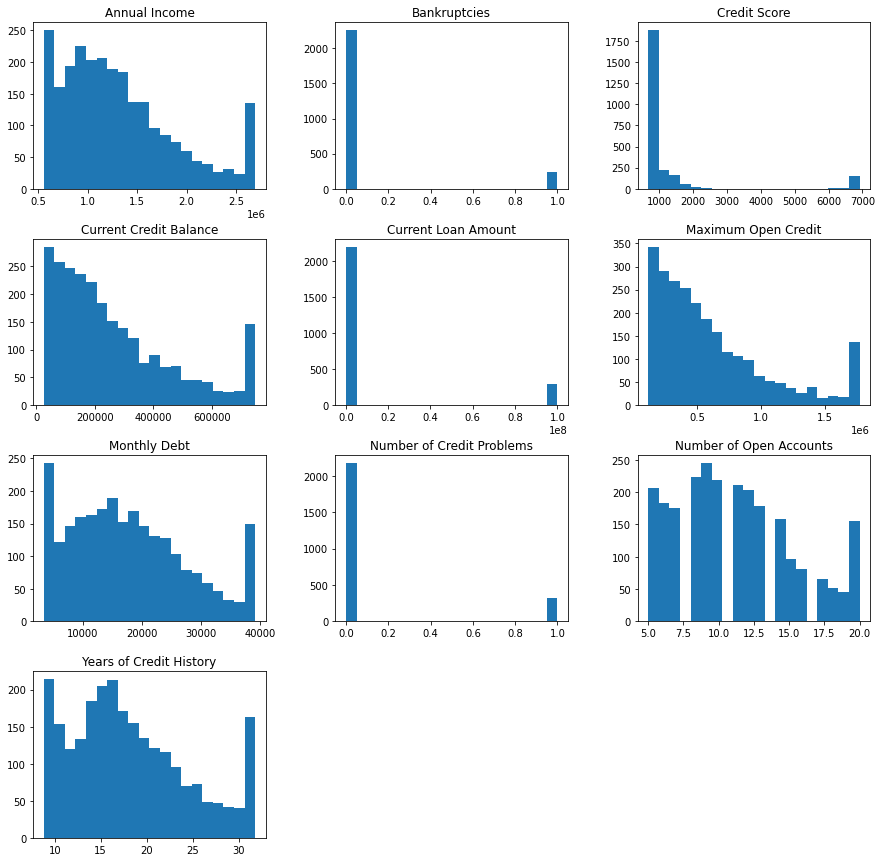

In [17]:
def clean_data():
    # преобразуем признаки в булевы значения
    print('...преобразуем признаки в булевы значения')
    to_bool_list = [['Term', 'Short Term', 'Long Term']]
    c_train.to_boolian(to_bool_list)
    c_test.to_boolian(to_bool_list)
    
    # На основе признаков "Home Ownership", "Purpose", "Years in current job" 
    # и построим новый справочник со стандартизированными значениями
    print('...построим новый справочник со стандартизированными категриальными значениями')
    corr_list = []
    corr_list.append(['Home Ownership', 'Home Mortgage', 'home_mortgage'])
    corr_list.append(['Home Ownership', 'Rent', 'rent'])
    corr_list.append(['Home Ownership', 'Own Home', 'own_home'])
    corr_list.append(['Home Ownership', 'Have Mortgage', 'home_mortgage'])

    corr_list.append(['Years in current job', '< 1 year', '<1'])
    corr_list.append(['Years in current job', '1 year', '1'])
    corr_list.append(['Years in current job', '2 years', '2'])
    corr_list.append(['Years in current job', '3 years', '3'])
    corr_list.append(['Years in current job', '4 years', '4'])
    corr_list.append(['Years in current job', '5 years', '5'])
    corr_list.append(['Years in current job', '6 years', '6'])
    corr_list.append(['Years in current job', '7 years', '7'])
    corr_list.append(['Years in current job', '8 years', '8'])
    corr_list.append(['Years in current job', '9 years', '9'])
    corr_list.append(['Years in current job', '10+ years', '10+'])

    corr_list.append(['Purpose', 'debt consolidation', 'debt'])
    corr_list.append(['Purpose', 'other', 'other'])
    corr_list.append(['Purpose', 'home improvements', 'home_improvement'])
    corr_list.append(['Purpose', 'buy a car', 'buy_car'])
    corr_list.append(['Purpose', 'business loan', 'business'])
    corr_list.append(['Purpose', 'medical bills', 'medical'])
    corr_list.append(['Purpose', 'buy house', 'buy_house'])
    corr_list.append(['Purpose', 'take a trip', 'trip'])
    corr_list.append(['Purpose', 'major purchase', 'other'])
    corr_list.append(['Purpose', 'small business', 'business'])
    corr_list.append(['Purpose', 'educational expenses', 'education'])
    corr_list.append(['Purpose', 'vacation ', 'trip'])
    corr_list.append(['Purpose', 'wedding', 'other'])
    corr_list.append(['Purpose', 'moving', 'other'])
    corr_list.append(['Purpose', 'renewable energy', 'other'])
    
    # Формируем стандартизированный справочник
    print('...скорректируем значения признаков в соответствии с новым справочником')
    c_train.cat_сorr_value(corr_list)
    c_test.cat_сorr_value(corr_list)
    
    # Удаляем признак "Months since last delinquent" в виду большого количества пропусков
    print('...удаляем признак "Months since last delinquent"')
    c_train.drop_feature('Months since last delinquent')
    c_test.drop_feature('Months since last delinquent')
    

    # Удаляем малоинформативный признак "Tax Liens"
    print('...удаляем признак Tax Liens')
    c_train.drop_feature('Tax Liens')
    c_test.drop_feature('Tax Liens')
    
    # Создадим признак ID (говорят полезно...)
    print('...добавляем признак ID')
    c_train.create_ID_feature()
    c_test.create_ID_feature()
    
    
    # Заполняем гапы в признаках
    print('...заполняем гапы в признаках')
    c_train.predict_missed_value(c_train.missed_features)
    c_test.predict_missed_value(c_train.missed_features)
    
#          #Новая функция пофиксить выбросы
#     c_train.outliers_fix(n_sigma = 2)
#     c_test.outliers_fix(n_sigma = 2)
#     print('...проверяем еще раз на выбросы и сравниваем качество удалениния')
#     c_train.out_sigma(n_sigma = 2)
#     c_test.out_sigma(n_sigma = 2)
    
    
    
    # Удаляем выбросы
    print('...удаляем выбросы')
    c_train.remove_outliers(limits = 0.05)
    c_test.remove_outliers(limits = 0.05)
    
#     c_train.X.loc[c_train.X['Credit Score'] > 850, 'Credit Score'] = c_train.X['Credit Score']/10
#     c_test.X.loc[c_test.X['Credit Score'] > 850, 'Credit Score'] = c_test.X['Credit Score']/10
    
    
    print('...проверяем еще раз на выбросы и сравниваем качество удалениния')
    c_train.out_sigma(n_sigma = 3)
    c_test.out_sigma(n_sigma = 3)
    
    
    
  
    
clean_data()

In [18]:
c_train.X.describe()

,Annual Income,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,ID
count,7.500000e+03,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,1.317657e+06,10.986133,18.139893,5.984671e+05,0.137467,0.110156,1.187427e+07,266144.709067,17817.839600,1144.825872,0.281733,3749.500000
std,5.762999e+05,4.226495,6.244871,4.253151e+05,0.344362,0.313069,3.192572e+07,201484.937701,10012.726613,1349.921243,0.449874,2134.600662
min,5.596830e+05,5.000000,9.000000,1.116280e+05,0.000000,0.000000,7.618600e+04,29602.000000,3684.000000,668.545455,0.000000,375.000000
25%,8.746392e+05,8.000000,13.500000,2.792295e+05,0.000000,0.000000,1.801690e+05,114256.500000,10067.500000,712.986722,0.000000,1874.750000
50%,1.197342e+06,10.000000,17.000000,4.781590e+05,0.000000,0.000000,3.095730e+05,209323.000000,16076.500000,733.000000,0.000000,3749.500000
75%,1.625065e+06,14.000000,21.800000,7.935015e+05,0.000000,0.000000,5.198820e+05,360406.250000,23818.000000,745.962103,1.000000,5624.250000
max,2.704688e+06,20.000000,31.900000,1.706320e+06,1.000000,1.000000,1.000000e+08,766536.000000,40546.000000,6560.000000,1.000000,7124.000000


#### Анализ признаков в разрезе их влияния на целевую переменную

**Описание методологии**

1. Вопервых нам надо определить каким образом значения категориальных признаков взаимно влияют на целевую переменную, иными словами одинаково они описывают взаимосвязь с целевой переменной или нет. В зависимости от этого, мы должны принять решение об объединении тех значений признака, которые одинаково влияют на целевую переменную и оставить те значения как есть, если они уникально влияют на целевую переменную

**Реализация методологии**

1. Для первоначальной грубой оценки мы должны сначала посмотреть на график кореляций признаков в разрезе целевой переменной. Соответственно создадим функцию в класссе очистки.

Cмотрим распределение целевой переменной на Train



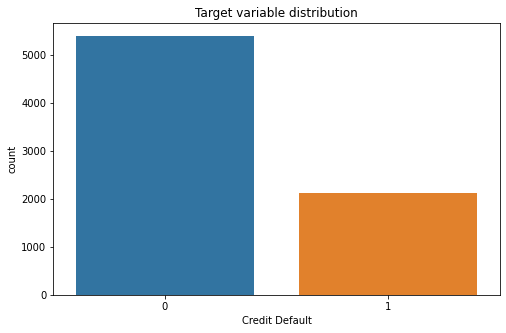

Кореляция признаков с таргетом на Train



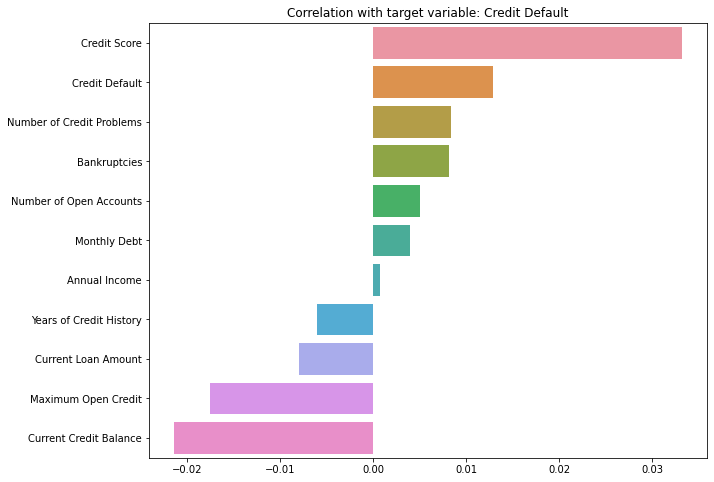

In [19]:
c_train.corr_base_target()

2. Далее производим оценку категориальных признаков в разрезе целевой переменной

Гипотеза            
 - Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы            
 - Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы            
 - Критерий: Хи-квадрат Пирсона            
 - Уровень значимости  𝛼 - 0.05            
 - Критическая область: двухсторонняя            
Для проверки данной гипотезы необходимо подать наблюдаемые частоты категорий исследуемого признака в выбранный критерий,            
после чего оценить значение достигаемого уровня значимости p-value и сравнить с его с выбранным порогом альфа,             
если p-value получится больше выбранного порога, то гипотезу о согласованности частот можно не отбрасывать


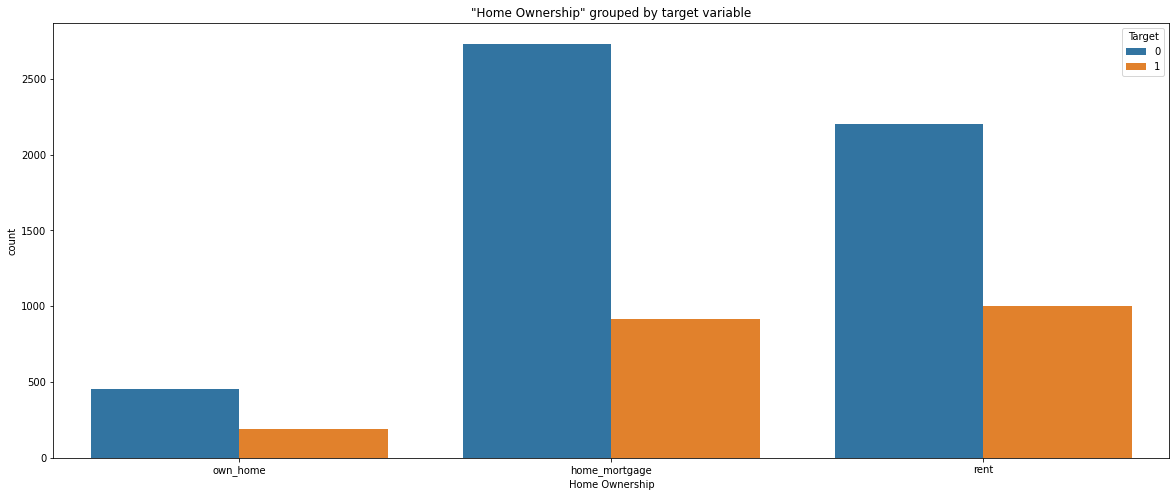

Следующие значения категорияльных признаков можно объединить
[['Home Ownership', ['own_home', 'rent']]]


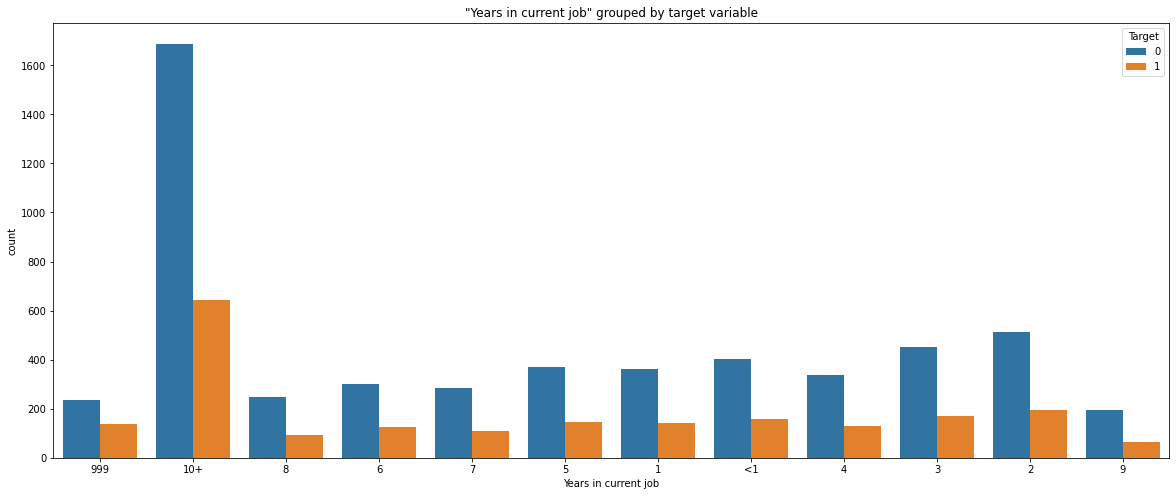

Следующие значения категорияльных признаков можно объединить
[['Years in current job', ['1', '10+', '2', '3', '4', '5', '6', '7', '8', '9', '<1']]]


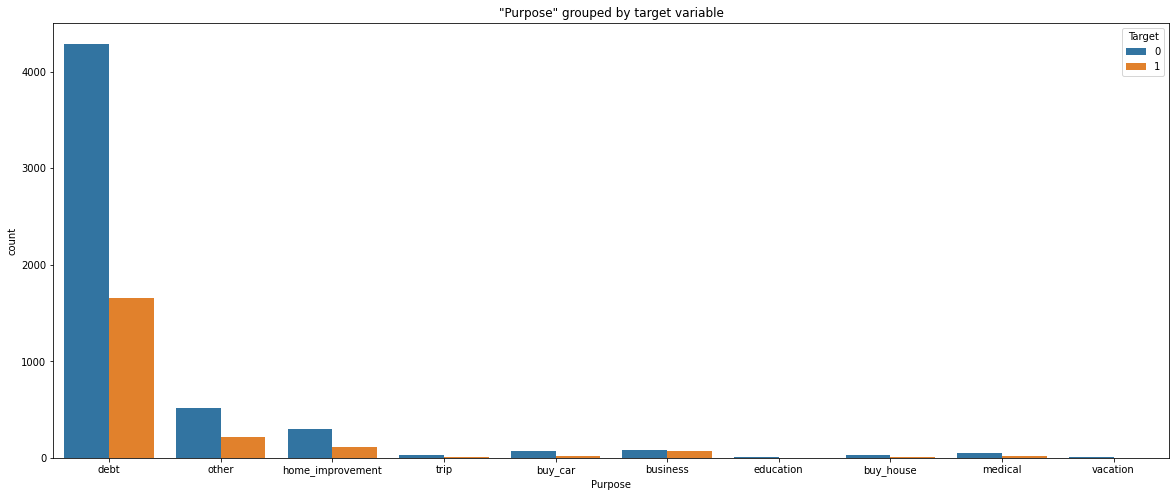

Следующие значения категорияльных признаков можно объединить
[['Purpose', ['buy_car', 'buy_house', 'debt', 'education', 'home_improvement', 'medical', 'other', 'trip', 'vacation']], ['Purpose', ['business', 'buy_house', 'medical', 'trip', 'vacation']], ['Purpose', ['business', 'buy_car', 'buy_house', 'debt', 'education', 'home_improvement', 'medical', 'other', 'trip', 'vacation']]]


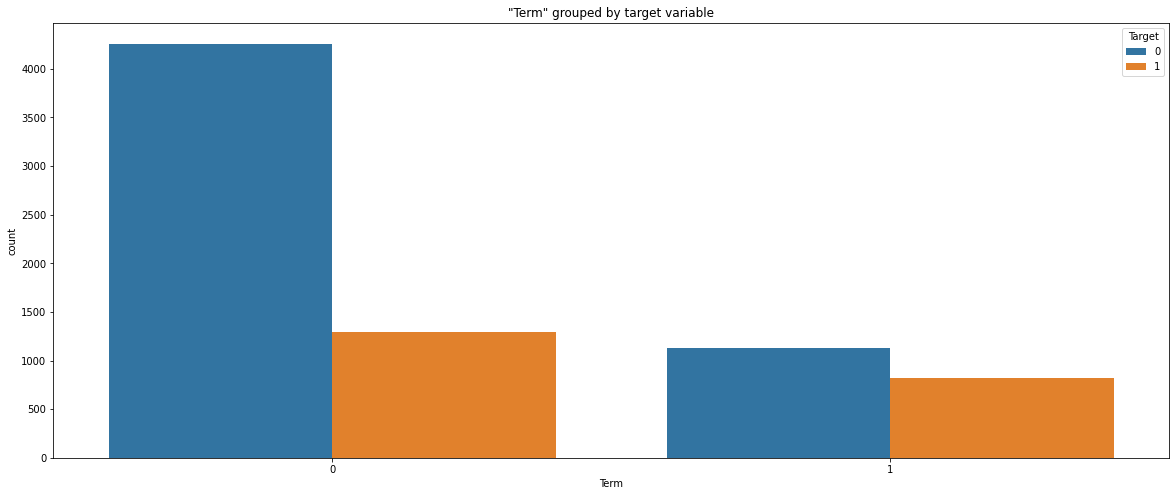

Следующие значения категорияльных признаков можно объединить
[]


In [20]:
c_train.cat_featere_target_estimate(alpha = 0.05)

2. Во-вторых, что касается численных признаков, мы должны определить насколько они влияют на целевую переменную после их разделения в разрезе значений целевой переменной. Иными словами, нужно смотреть являются ли распределения этих подгрупп независимыми. Если да, то данный признак будет полезен и его оставляем, если нет, то признак можно выбросить из модели.

Реализация методологии

Гипотеза            
 - Нулевая гипотеза: Нулевая гипотеза: средние значения в двух независимых выборках равны            
 - Альтернативная гипотеза: средние значения в двух независимых выборках различаются            
 - Критерий: критерий Стьюдента (t-тест) и его аналоги            
 - Уровень значимости  𝛼 - 0.05            
 - Критическая область: двухсторонняя            
Что бы проверить данную гипотезу сравним две выборки из рассматриваемых групп на предмет            
равенства средних значений. Если вероятность того, что мат. ожидания в исходных группах равны,            
при данных выборках, буде менее 5%, то можно будет говорить о том,            
что скорее всего выборки имеют различные распределения.
Оценка признака "Annual Income" в разрезе целевой переменной "Credit Default"



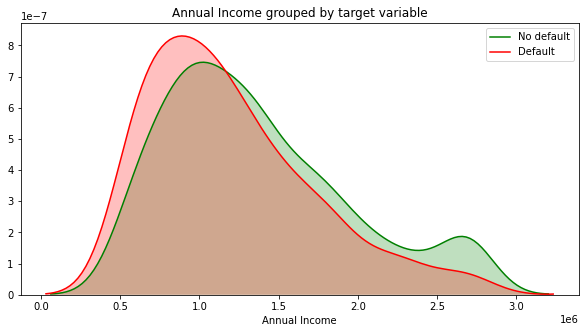

 p_value = 4.364123930524688e-22, меньше alpha = 0.05 - гипотеза о "нормальности" отвергается.

Для достоверности произведём визуальную оценку распределения признака


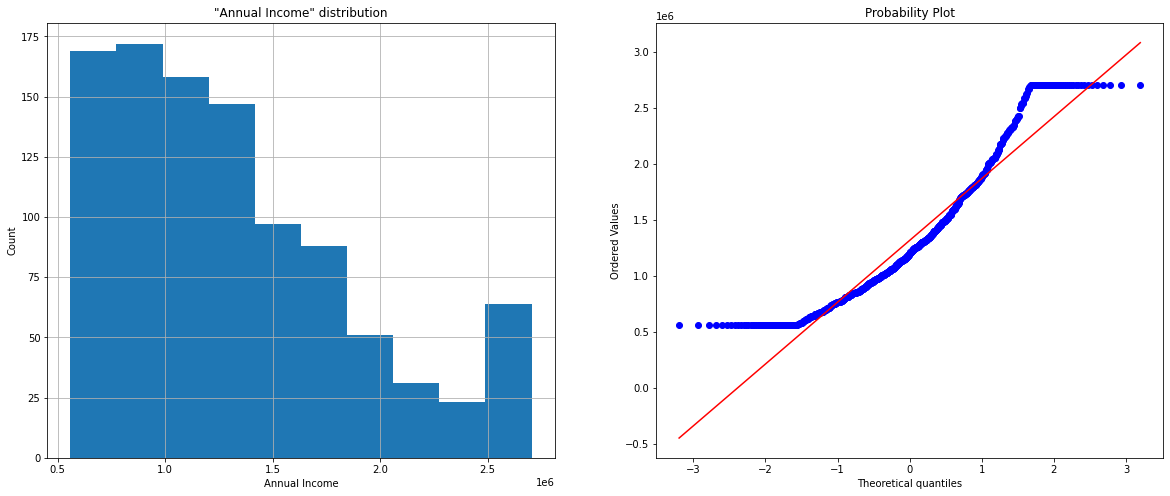

Попробуем проверить признак на нормальность после его стандартизирования
статистика = 0.9765658378601074, p_value = 1.2823410736051422e-11



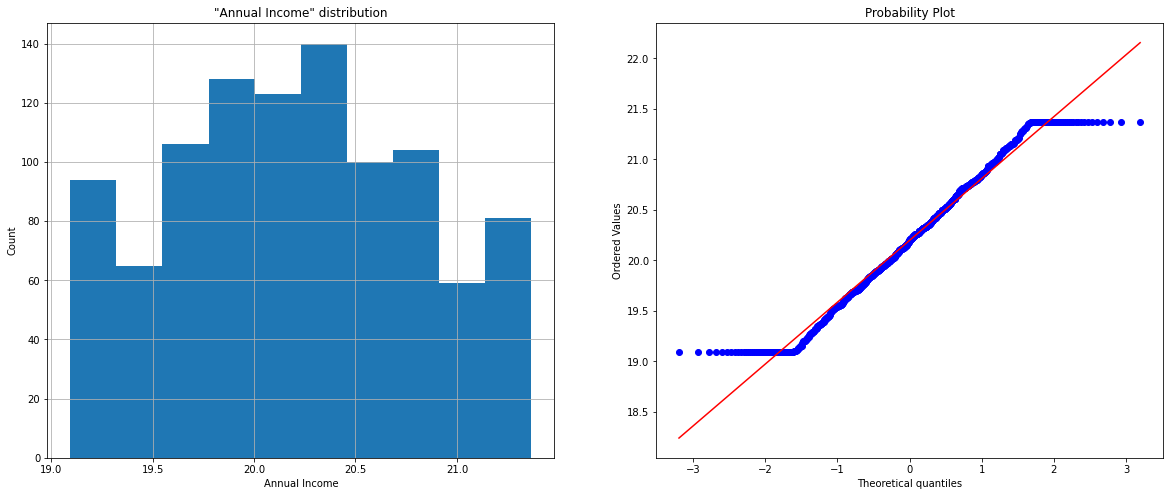

 p_value = 1.2823410736051422e-11, меньше alpha = 0.05 - гипотеза о "нормальности" отвергается.

Визуальная оценка подтверждает показания критерия Шапиро-Уилка:                        
что закон распределения отличный от "нормального" поэтому мы не сможем воспользоваться критерием                        
Стьюдента для проверки гипотезы о равности мат. ожиданий признака Annual Income, но мы сможем воспользоваться его непараметрическим                        
аналогом - критерием Манна-Уитни, который не требователен к закону распределения

Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни

Согласно значению p-value 1.092960324580018e-05 , гипотеза о равности мат. ожиданий отвергается.,                
но стоит ради дополнительной проверки обратиться к доверительным интервалам.

Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их



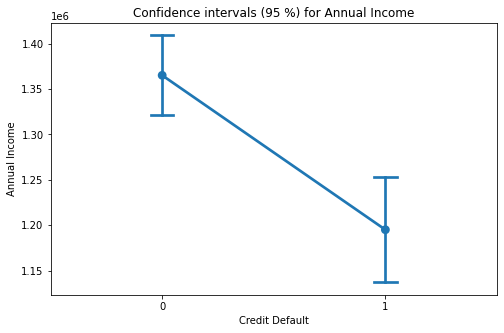

Оценка признака "Number of Open Accounts" в разрезе целевой переменной "Credit Default"



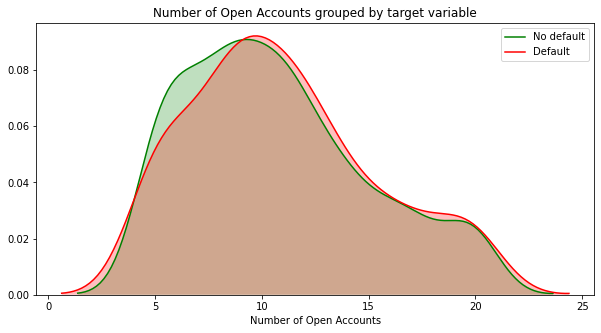

 p_value = 5.011895409394464e-20, меньше alpha = 0.05 - гипотеза о "нормальности" отвергается.

Для достоверности произведём визуальную оценку распределения признака


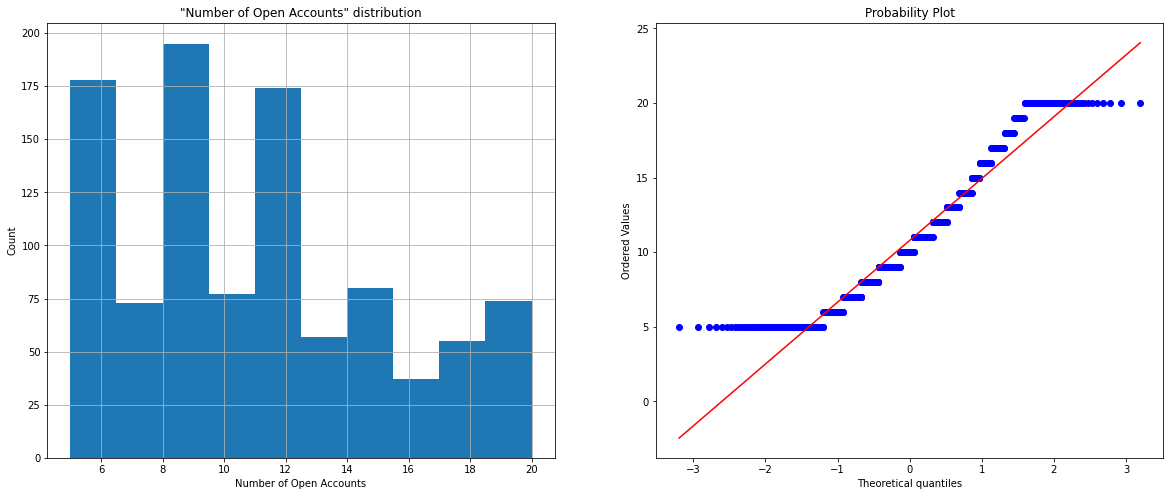

Попробуем проверить признак на нормальность после его стандартизирования
статистика = 0.9579280614852905, p_value = 2.3543524290905614e-16



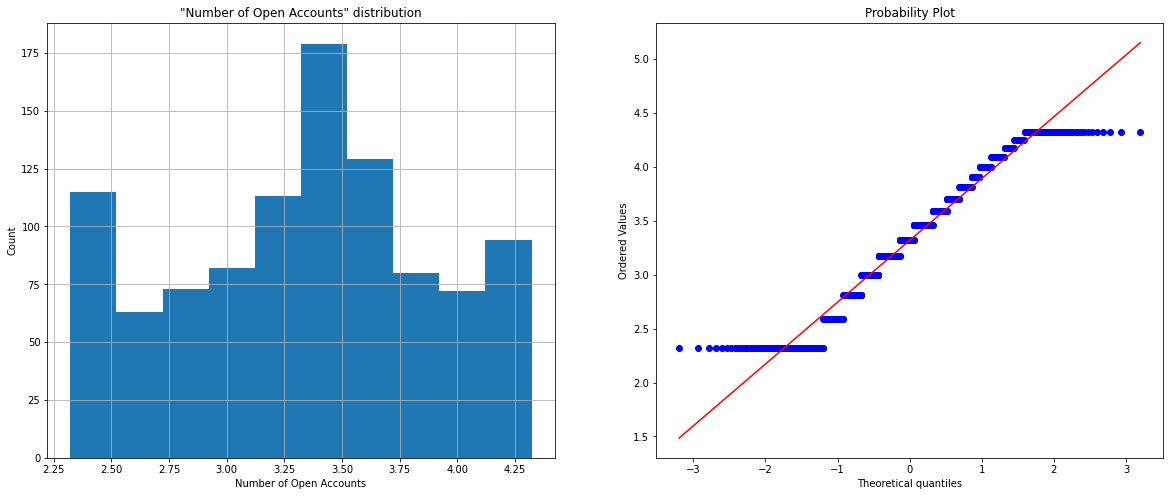

 p_value = 2.3543524290905614e-16, меньше alpha = 0.05 - гипотеза о "нормальности" отвергается.

Визуальная оценка подтверждает показания критерия Шапиро-Уилка:                        
что закон распределения отличный от "нормального" поэтому мы не сможем воспользоваться критерием                        
Стьюдента для проверки гипотезы о равности мат. ожиданий признака Number of Open Accounts, но мы сможем воспользоваться его непараметрическим                        
аналогом - критерием Манна-Уитни, который не требователен к закону распределения

Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни

Согласно значению p-value 0.1782651345721154 , гипотеза о равности мат. ожиданий подтверждается,                
но стоит ради дополнительной проверки обратиться к доверительным интервалам.

Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их



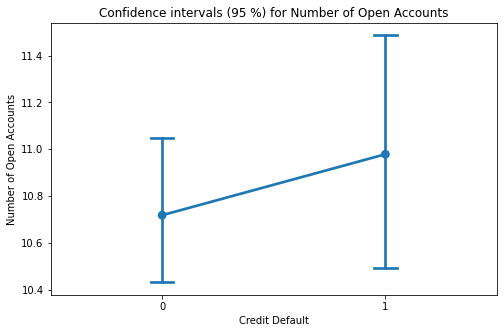

Оценка признака "Years of Credit History" в разрезе целевой переменной "Credit Default"



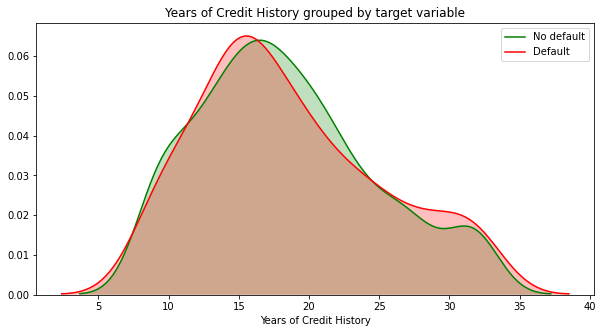

 p_value = 2.5160676946825564e-17, меньше alpha = 0.05 - гипотеза о "нормальности" отвергается.

Для достоверности произведём визуальную оценку распределения признака


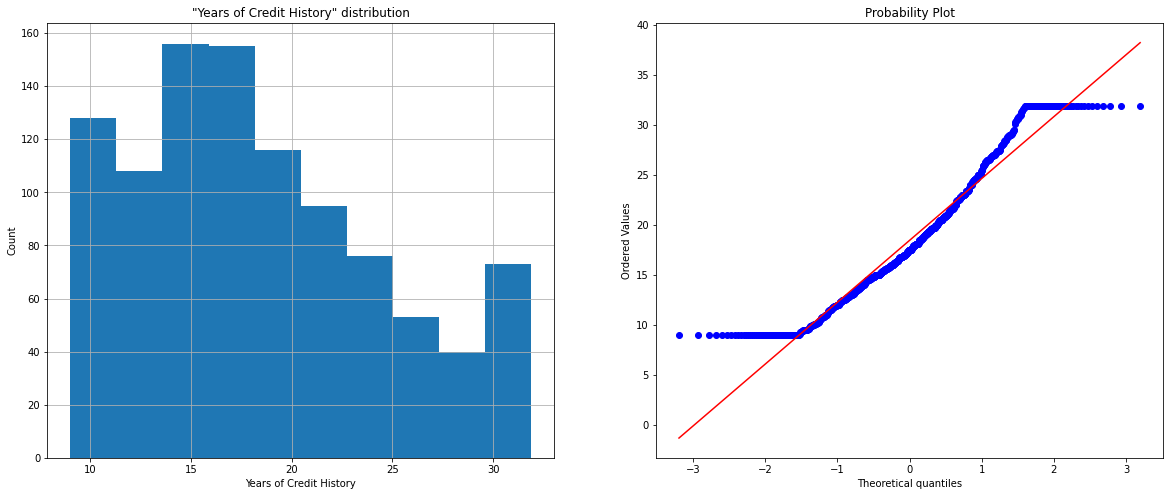

Попробуем проверить признак на нормальность после его стандартизирования
статистика = 0.9722927808761597, p_value = 6.981694410969352e-13



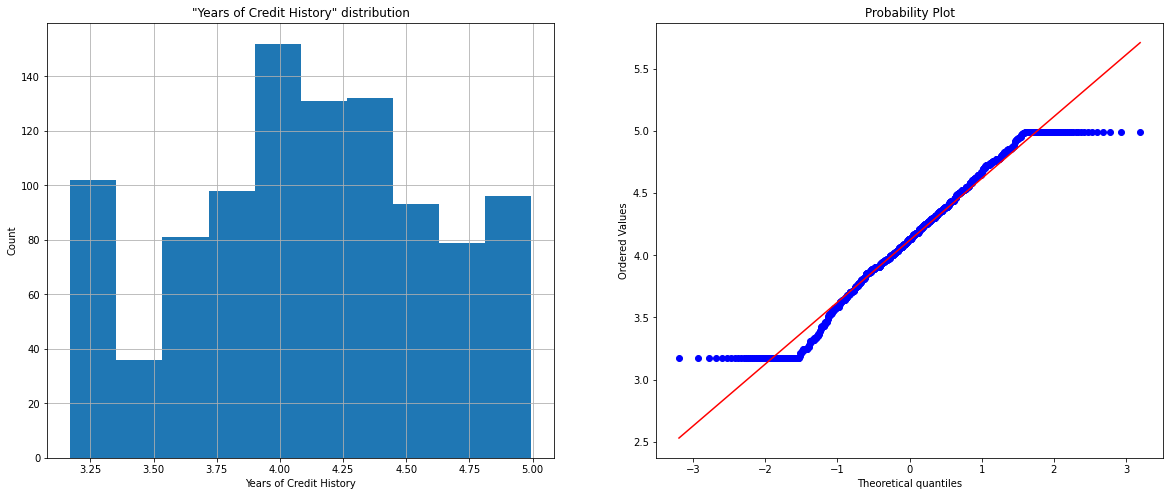

 p_value = 6.981694410969352e-13, меньше alpha = 0.05 - гипотеза о "нормальности" отвергается.

Визуальная оценка подтверждает показания критерия Шапиро-Уилка:                        
что закон распределения отличный от "нормального" поэтому мы не сможем воспользоваться критерием                        
Стьюдента для проверки гипотезы о равности мат. ожиданий признака Years of Credit History, но мы сможем воспользоваться его непараметрическим                        
аналогом - критерием Манна-Уитни, который не требователен к закону распределения

Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни

Согласно значению p-value 0.442430516858562 , гипотеза о равности мат. ожиданий подтверждается,                
но стоит ради дополнительной проверки обратиться к доверительным интервалам.

Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их



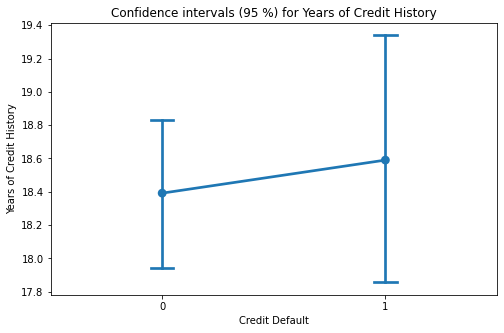

Оценка признака "Maximum Open Credit" в разрезе целевой переменной "Credit Default"



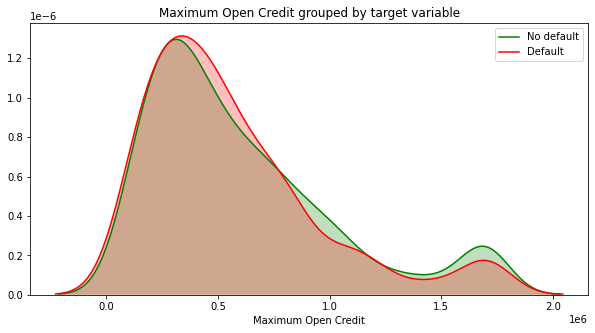

 p_value = 5.169058266744317e-28, меньше alpha = 0.05 - гипотеза о "нормальности" отвергается.

Для достоверности произведём визуальную оценку распределения признака


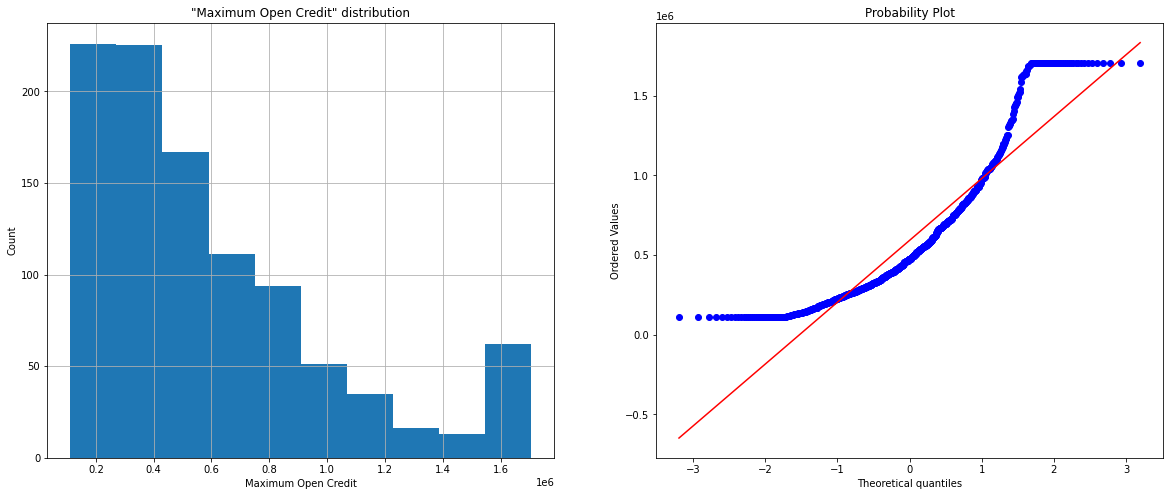

Попробуем проверить признак на нормальность после его стандартизирования
статистика = 0.979929506778717, p_value = 1.6296472504784276e-10



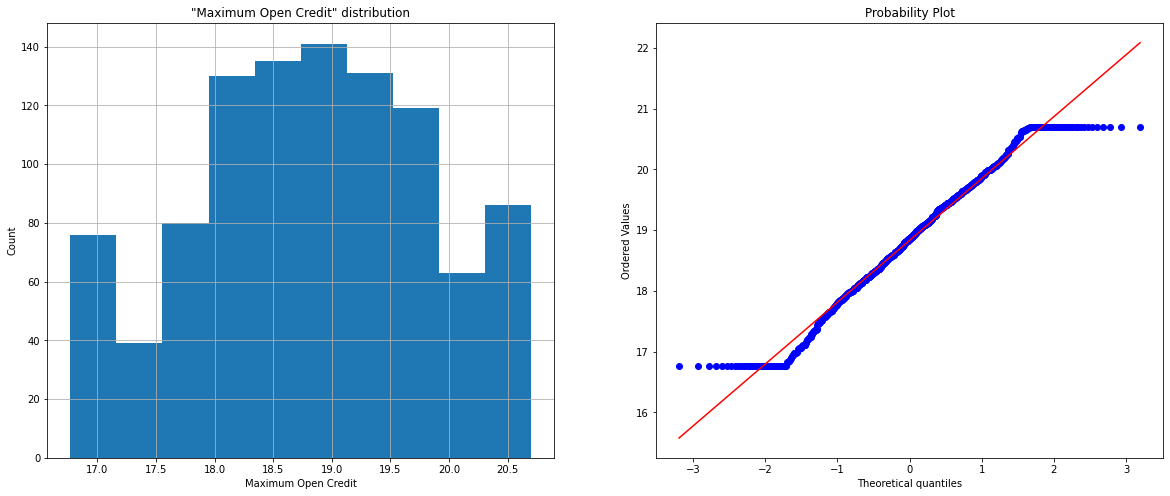

 p_value = 1.6296472504784276e-10, меньше alpha = 0.05 - гипотеза о "нормальности" отвергается.

Визуальная оценка подтверждает показания критерия Шапиро-Уилка:                        
что закон распределения отличный от "нормального" поэтому мы не сможем воспользоваться критерием                        
Стьюдента для проверки гипотезы о равности мат. ожиданий признака Maximum Open Credit, но мы сможем воспользоваться его непараметрическим                        
аналогом - критерием Манна-Уитни, который не требователен к закону распределения

Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни

Согласно значению p-value 0.12744211658088583 , гипотеза о равности мат. ожиданий подтверждается,                
но стоит ради дополнительной проверки обратиться к доверительным интервалам.

Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их



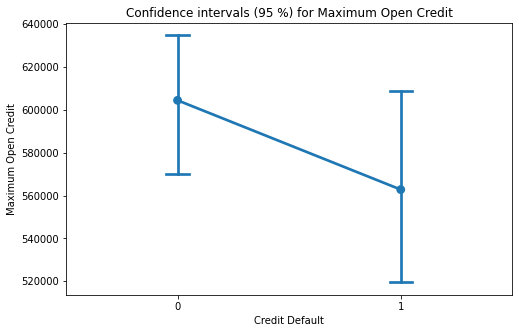

Оценка признака "Number of Credit Problems" в разрезе целевой переменной "Credit Default"



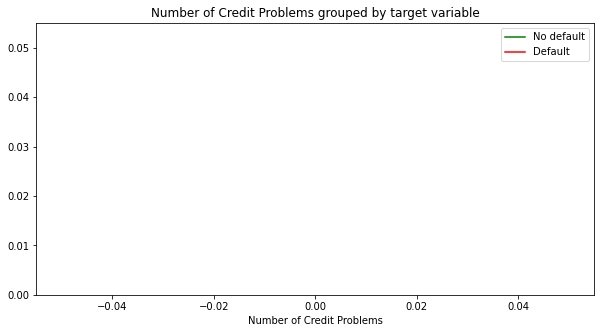

 p_value = 0.0, меньше alpha = 0.05 - гипотеза о "нормальности" отвергается.

Для достоверности произведём визуальную оценку распределения признака


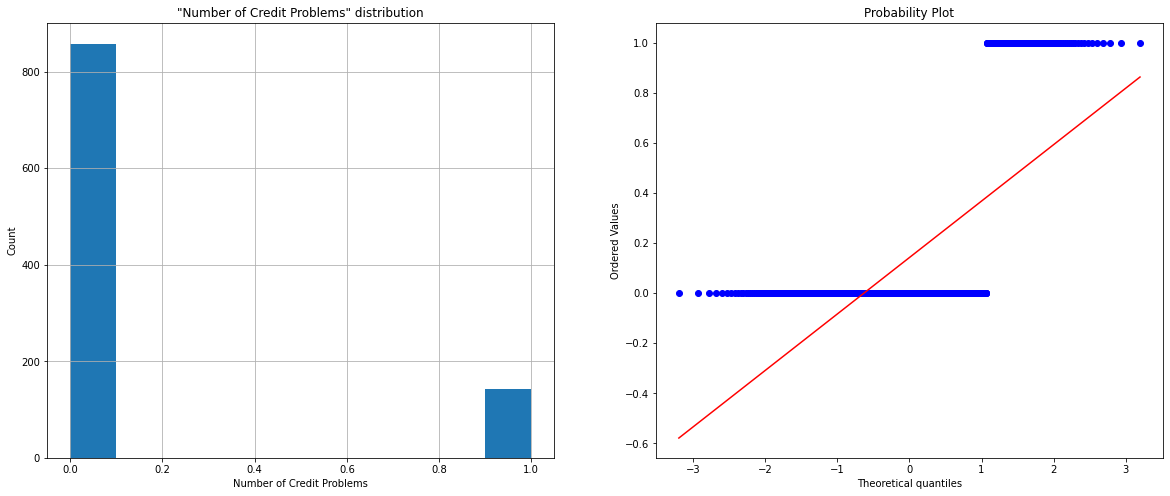

Попробуем проверить признак на нормальность после его стандартизирования
статистика = nan, p_value = 1.0

Признак Number of Credit Problems невозможно корректно стандратизировать, делаем окончательный вывод о том,                    
что его распределение неноромально

Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни

Согласно значению p-value 0.48575253818293035 , гипотеза о равности мат. ожиданий подтверждается,                
но стоит ради дополнительной проверки обратиться к доверительным интервалам.

Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их



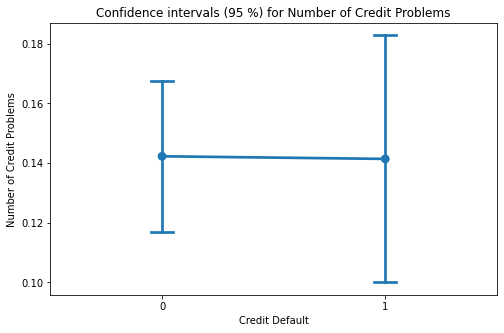

Оценка признака "Bankruptcies" в разрезе целевой переменной "Credit Default"



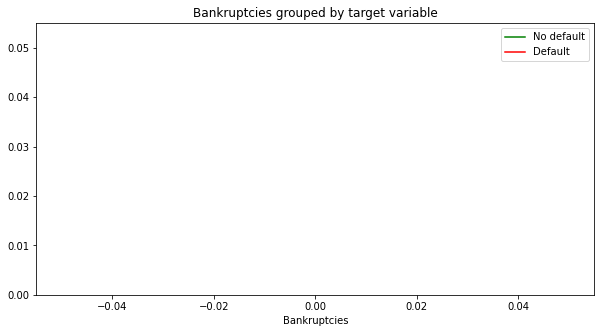

 p_value = 0.0, меньше alpha = 0.05 - гипотеза о "нормальности" отвергается.

Для достоверности произведём визуальную оценку распределения признака


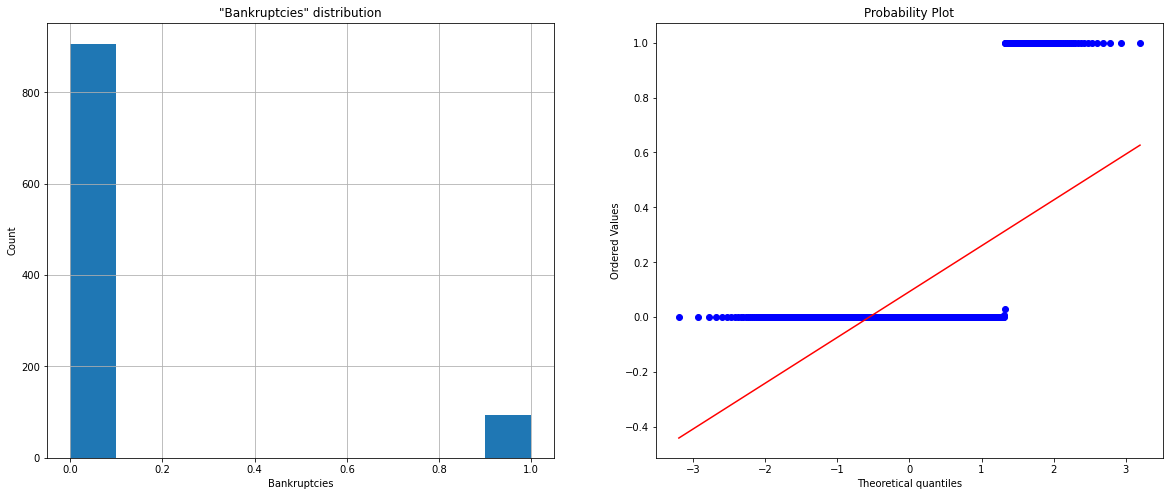

Попробуем проверить признак на нормальность после его стандартизирования
статистика = nan, p_value = 1.0

Признак Bankruptcies невозможно корректно стандратизировать, делаем окончательный вывод о том,                    
что его распределение неноромально

Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни

Согласно значению p-value 0.35716333139290807 , гипотеза о равности мат. ожиданий подтверждается,                
но стоит ради дополнительной проверки обратиться к доверительным интервалам.

Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их



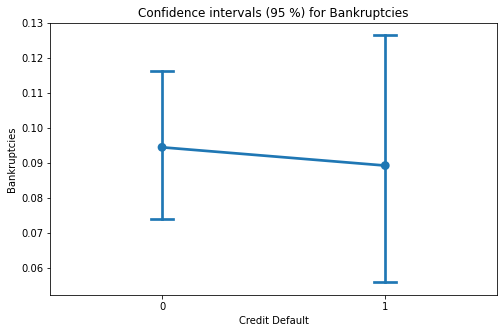

Оценка признака "Current Loan Amount" в разрезе целевой переменной "Credit Default"



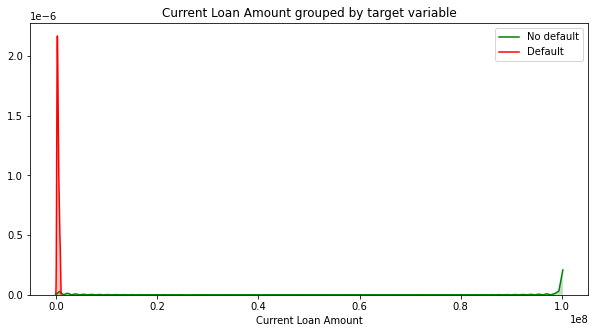

 p_value = 0.0, меньше alpha = 0.05 - гипотеза о "нормальности" отвергается.

Для достоверности произведём визуальную оценку распределения признака


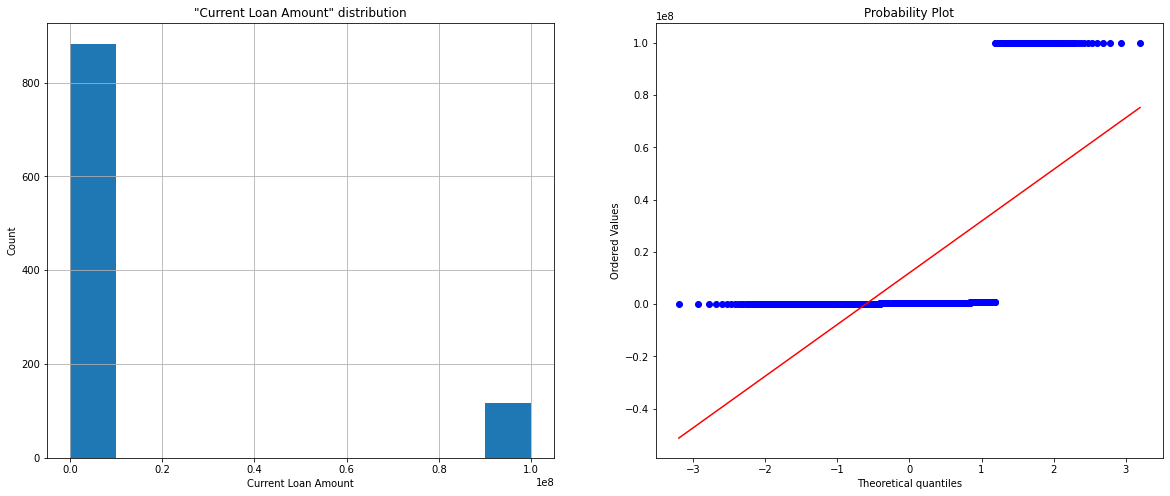

Попробуем проверить признак на нормальность после его стандартизирования
статистика = 0.6561170816421509, p_value = 8.674037494170618e-41



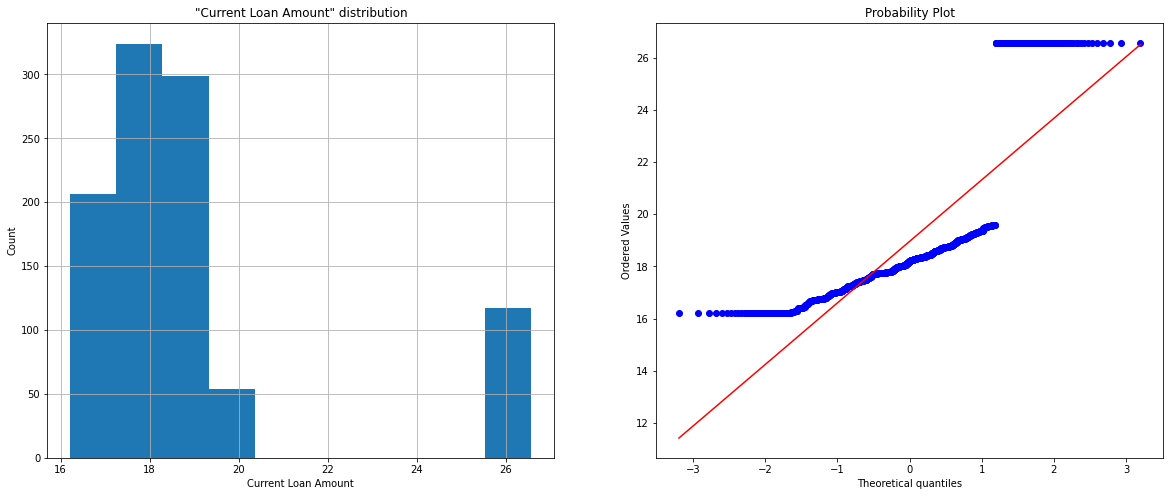

 p_value = 8.674037494170618e-41, меньше alpha = 0.05 - гипотеза о "нормальности" отвергается.

Визуальная оценка подтверждает показания критерия Шапиро-Уилка:                        
что закон распределения отличный от "нормального" поэтому мы не сможем воспользоваться критерием                        
Стьюдента для проверки гипотезы о равности мат. ожиданий признака Current Loan Amount, но мы сможем воспользоваться его непараметрическим                        
аналогом - критерием Манна-Уитни, который не требователен к закону распределения

Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни

Согласно значению p-value 0.0036468798840484117 , гипотеза о равности мат. ожиданий отвергается.,                
но стоит ради дополнительной проверки обратиться к доверительным интервалам.

Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их



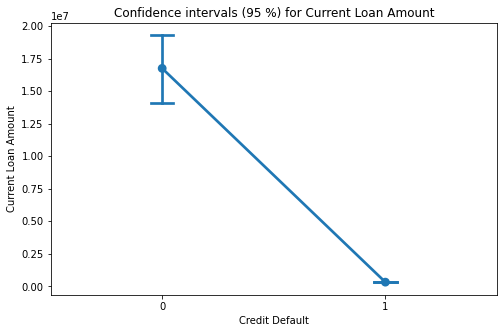

Оценка признака "Current Credit Balance" в разрезе целевой переменной "Credit Default"



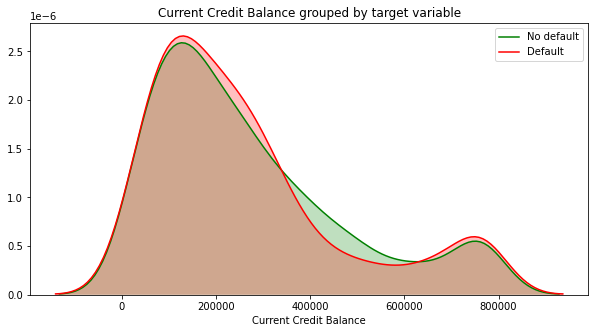

 p_value = 8.49439587174254e-28, меньше alpha = 0.05 - гипотеза о "нормальности" отвергается.

Для достоверности произведём визуальную оценку распределения признака


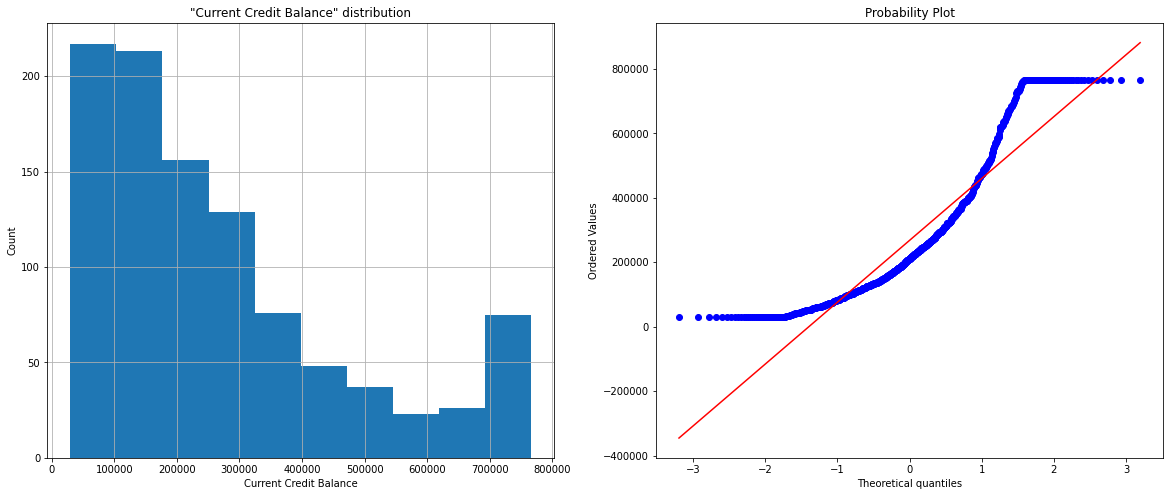

Попробуем проверить признак на нормальность после его стандартизирования
статистика = 0.9705766439437866, p_value = 2.358071962520192e-13



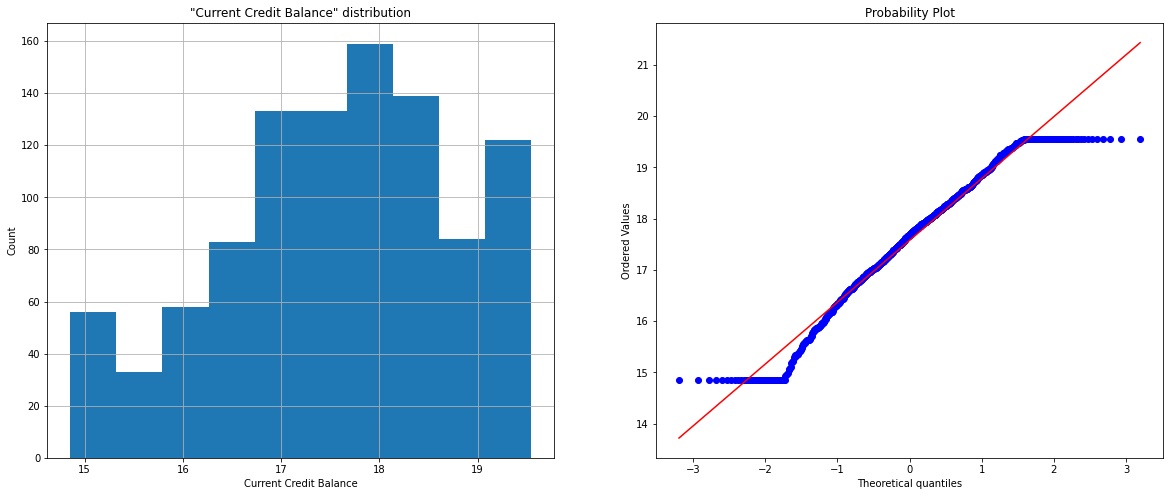

 p_value = 2.358071962520192e-13, меньше alpha = 0.05 - гипотеза о "нормальности" отвергается.

Визуальная оценка подтверждает показания критерия Шапиро-Уилка:                        
что закон распределения отличный от "нормального" поэтому мы не сможем воспользоваться критерием                        
Стьюдента для проверки гипотезы о равности мат. ожиданий признака Current Credit Balance, но мы сможем воспользоваться его непараметрическим                        
аналогом - критерием Манна-Уитни, который не требователен к закону распределения

Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни

Согласно значению p-value 0.2870877192798148 , гипотеза о равности мат. ожиданий подтверждается,                
но стоит ради дополнительной проверки обратиться к доверительным интервалам.

Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их



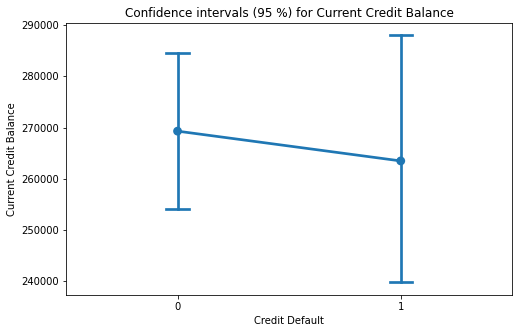

Оценка признака "Monthly Debt" в разрезе целевой переменной "Credit Default"



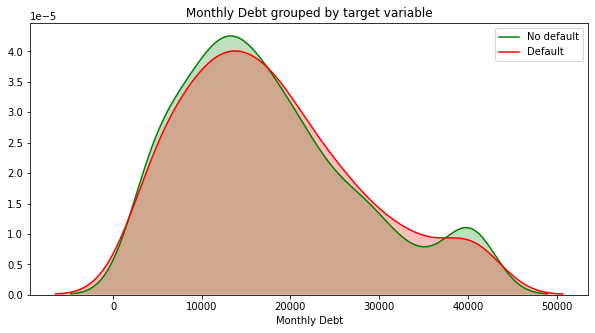

 p_value = 1.9644757603961603e-20, меньше alpha = 0.05 - гипотеза о "нормальности" отвергается.

Для достоверности произведём визуальную оценку распределения признака


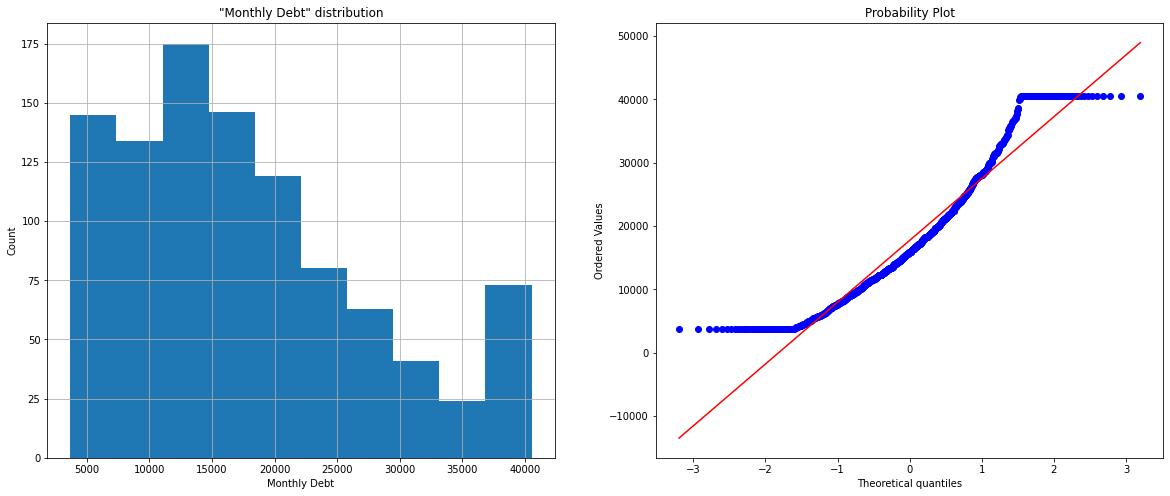

Попробуем проверить признак на нормальность после его стандартизирования
статистика = 0.9601613283157349, p_value = 7.099679286141816e-16



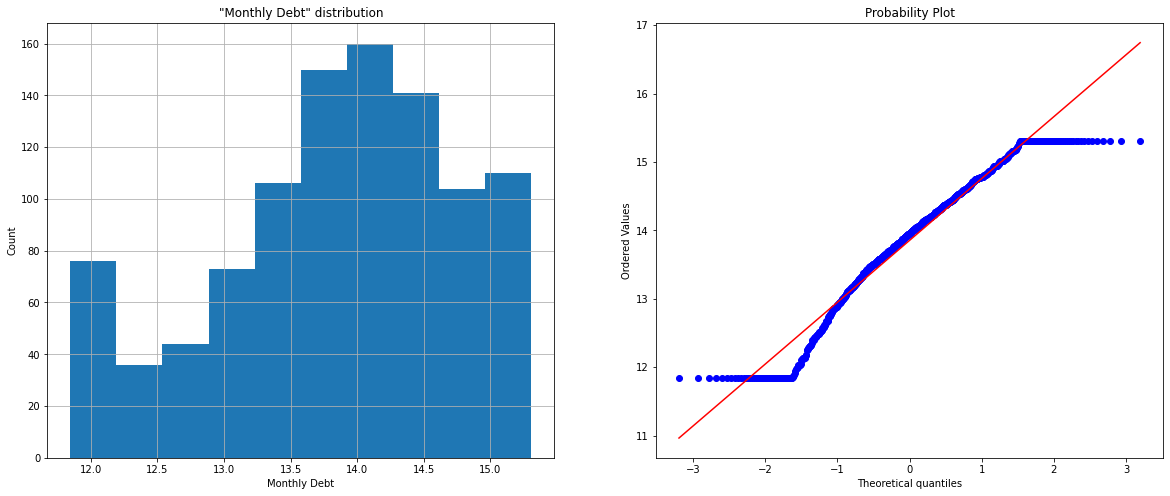

 p_value = 7.099679286141816e-16, меньше alpha = 0.05 - гипотеза о "нормальности" отвергается.

Визуальная оценка подтверждает показания критерия Шапиро-Уилка:                        
что закон распределения отличный от "нормального" поэтому мы не сможем воспользоваться критерием                        
Стьюдента для проверки гипотезы о равности мат. ожиданий признака Monthly Debt, но мы сможем воспользоваться его непараметрическим                        
аналогом - критерием Манна-Уитни, который не требователен к закону распределения

Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни

Согласно значению p-value 0.2983707894951031 , гипотеза о равности мат. ожиданий подтверждается,                
но стоит ради дополнительной проверки обратиться к доверительным интервалам.

Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их



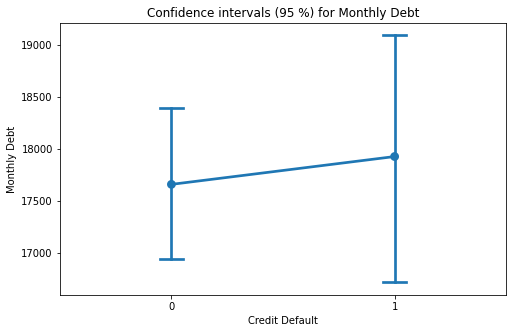

Оценка признака "Credit Score" в разрезе целевой переменной "Credit Default"



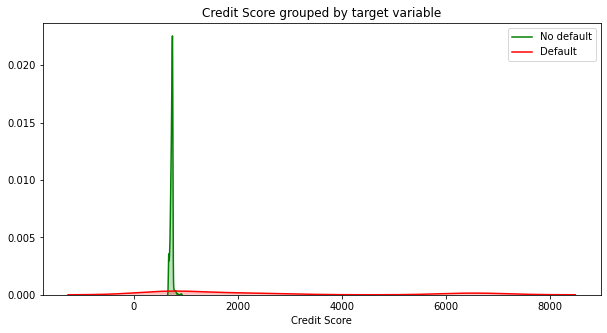

 p_value = 0.0, меньше alpha = 0.05 - гипотеза о "нормальности" отвергается.

Для достоверности произведём визуальную оценку распределения признака


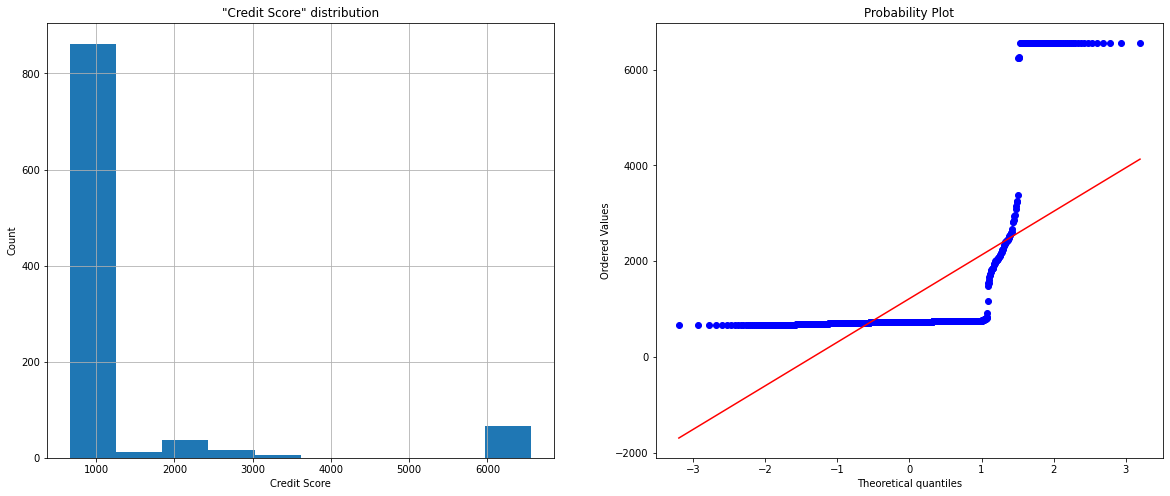

Попробуем проверить признак на нормальность после его стандартизирования
статистика = 0.46494895219802856, p_value = 0.0



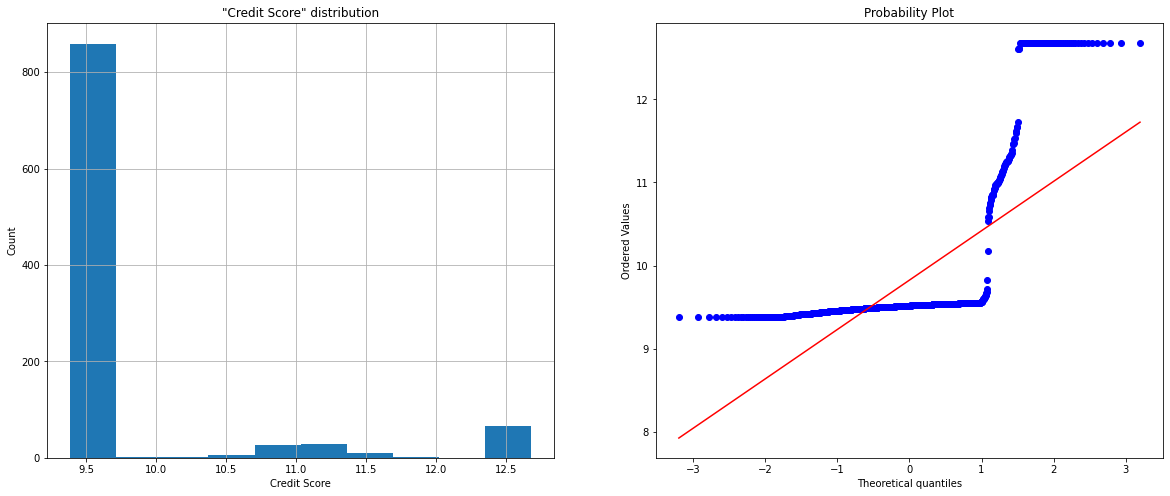

 p_value = 0.0, меньше alpha = 0.05 - гипотеза о "нормальности" отвергается.

Визуальная оценка подтверждает показания критерия Шапиро-Уилка:                        
что закон распределения отличный от "нормального" поэтому мы не сможем воспользоваться критерием                        
Стьюдента для проверки гипотезы о равности мат. ожиданий признака Credit Score, но мы сможем воспользоваться его непараметрическим                        
аналогом - критерием Манна-Уитни, который не требователен к закону распределения

Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни

Согласно значению p-value 1.0894332699235943e-19 , гипотеза о равности мат. ожиданий отвергается.,                
но стоит ради дополнительной проверки обратиться к доверительным интервалам.

Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их



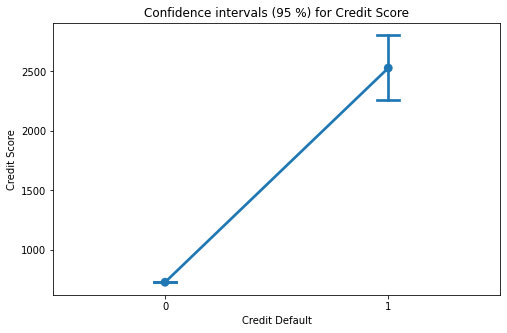

Оценка признака "ID" в разрезе целевой переменной "Credit Default"



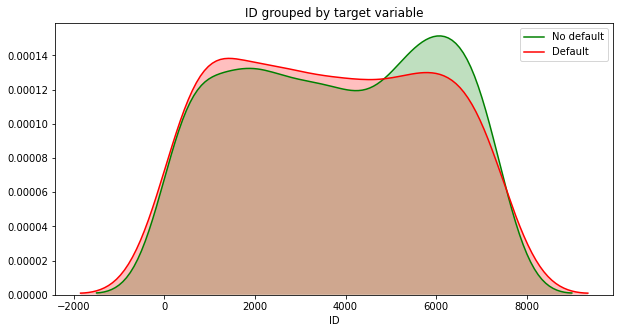

 p_value = 2.930099588744142e-20, меньше alpha = 0.05 - гипотеза о "нормальности" отвергается.

Для достоверности произведём визуальную оценку распределения признака


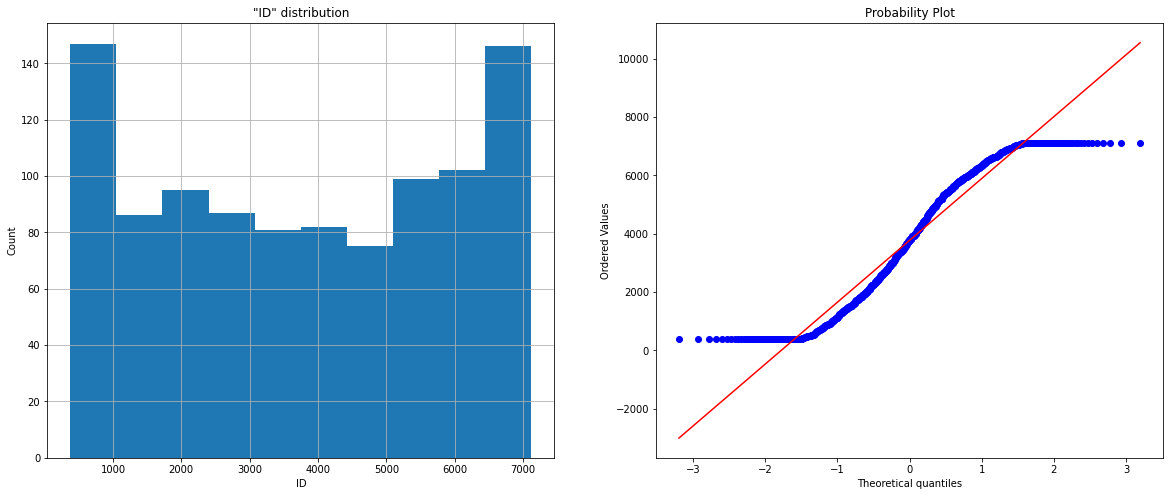

Попробуем проверить признак на нормальность после его стандартизирования
статистика = 0.8603867888450623, p_value = 7.07445346458201e-29



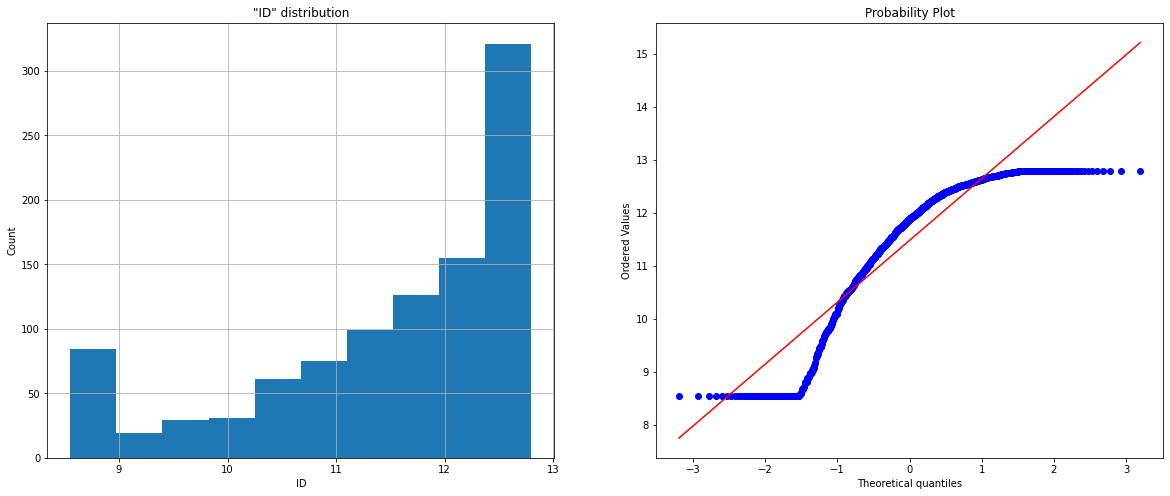

 p_value = 7.07445346458201e-29, меньше alpha = 0.05 - гипотеза о "нормальности" отвергается.

Визуальная оценка подтверждает показания критерия Шапиро-Уилка:                        
что закон распределения отличный от "нормального" поэтому мы не сможем воспользоваться критерием                        
Стьюдента для проверки гипотезы о равности мат. ожиданий признака ID, но мы сможем воспользоваться его непараметрическим                        
аналогом - критерием Манна-Уитни, который не требователен к закону распределения

Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни

Согласно значению p-value 0.18699950112962077 , гипотеза о равности мат. ожиданий подтверждается,                
но стоит ради дополнительной проверки обратиться к доверительным интервалам.

Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их



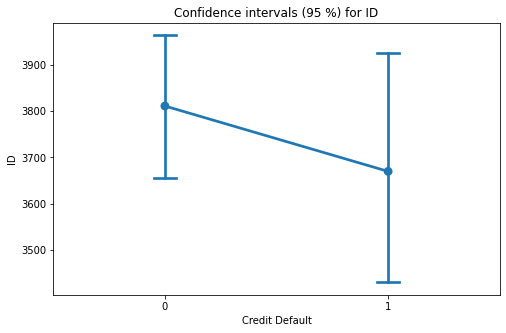

In [21]:
c_train.num_featere_target_estimate()

Посмотрм на категориальные признаки, которые можно объединить:

In [22]:
for f in c_train.features_for_join:
    for s in f:
        print(f'В признаке "{s[0]}" можно объединить следующие категории: {s[1]}')

В признаке "Home Ownership" можно объединить следующие категории: ['own_home', 'rent']
В признаке "Years in current job" можно объединить следующие категории: ['1', '10+', '2', '3', '4', '5', '6', '7', '8', '9', '<1']
В признаке "Purpose" можно объединить следующие категории: ['buy_car', 'buy_house', 'debt', 'education', 'home_improvement', 'medical', 'other', 'trip', 'vacation']
В признаке "Purpose" можно объединить следующие категории: ['business', 'buy_house', 'medical', 'trip', 'vacation']
В признаке "Purpose" можно объединить следующие категории: ['business', 'buy_car', 'buy_house', 'debt', 'education', 'home_improvement', 'medical', 'other', 'trip', 'vacation']


В функцию очистки deep_clean_data() добавим соответствующее действие по объединению выявленных категорий 'own_home', 'rent' признака "Home Ownership"

Признак "Years in current job" где выявленные для объединения все категории не имеет смысла использовать, так как после обхединения он станет малоинформативным. Поэтому удалим его.

Признак "Purpose" с аналогичной ситуацией, удаляем его тоже


Посмотрм на численные признаки, которые полезны для модели (мат, ожидание 2х групп в разрезе целевой переменной неравны):

In [23]:
c_train.features_with_NO_equel_math_ecpectation

['Annual Income', 'Current Loan Amount', 'Credit Score']

In [24]:
c_train.features_with_equel_math_ecpectation

['Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Bankruptcies',
 'Current Credit Balance',
 'Monthly Debt',
 'ID']

In [25]:
c_train.X

,Home Ownership,Annual Income,Years in current job,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,ID
0,own_home,5.596830e+05,999,11.0,26.3,685960.0,1.0,1.0,debt,0,99999999.0,47386.0,7914.0,749.000000,0,375
1,own_home,1.025487e+06,10+,15.0,15.3,1181730.0,0.0,0.0,debt,1,264968.0,394972.0,18373.0,737.000000,1,375
2,home_mortgage,7.514120e+05,8,11.0,31.9,1182434.0,0.0,0.0,debt,0,99999999.0,308389.0,13651.0,742.000000,0,375
3,own_home,8.050680e+05,6,8.0,22.5,147400.0,1.0,1.0,debt,0,121396.0,95855.0,11338.0,694.000000,0,375
4,rent,7.762640e+05,8,13.0,13.6,385836.0,1.0,0.0,debt,0,125840.0,93309.0,7180.0,719.000000,0,375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,rent,5.596830e+05,<1,5.0,9.0,111628.0,0.0,0.0,other,0,129360.0,73492.0,3684.0,697.000000,0,7124
7496,home_mortgage,1.533984e+06,1,10.0,26.5,686312.0,0.0,0.0,debt,1,444048.0,456399.0,12783.0,6560.000000,1,7124
7497,rent,1.878910e+06,6,12.0,31.9,1706320.0,0.0,0.0,buy_car,0,99999999.0,477812.0,12479.0,748.000000,0,7124
7498,home_mortgage,2.251842e+06,999,20.0,26.5,1141250.0,0.0,0.0,debt,0,615274.0,476064.0,37118.0,1045.273934,0,7124


Не будем пока удалять эти признаки как слабо влияющие на предсказание целевой переменной, вполне вероятно, это мы сделаем при оценке важности при построении финалной модели

...построим новый справочник со стандартизированными категриальными значениями
...скорректируем значения признаков в соответствии с новым справочником
...удалим признаки "Years in current job" и "Purpose" как потенциально малоинфомативные
<class 'Exception'>
<class 'Exception'>
...добавляем dummy переменные


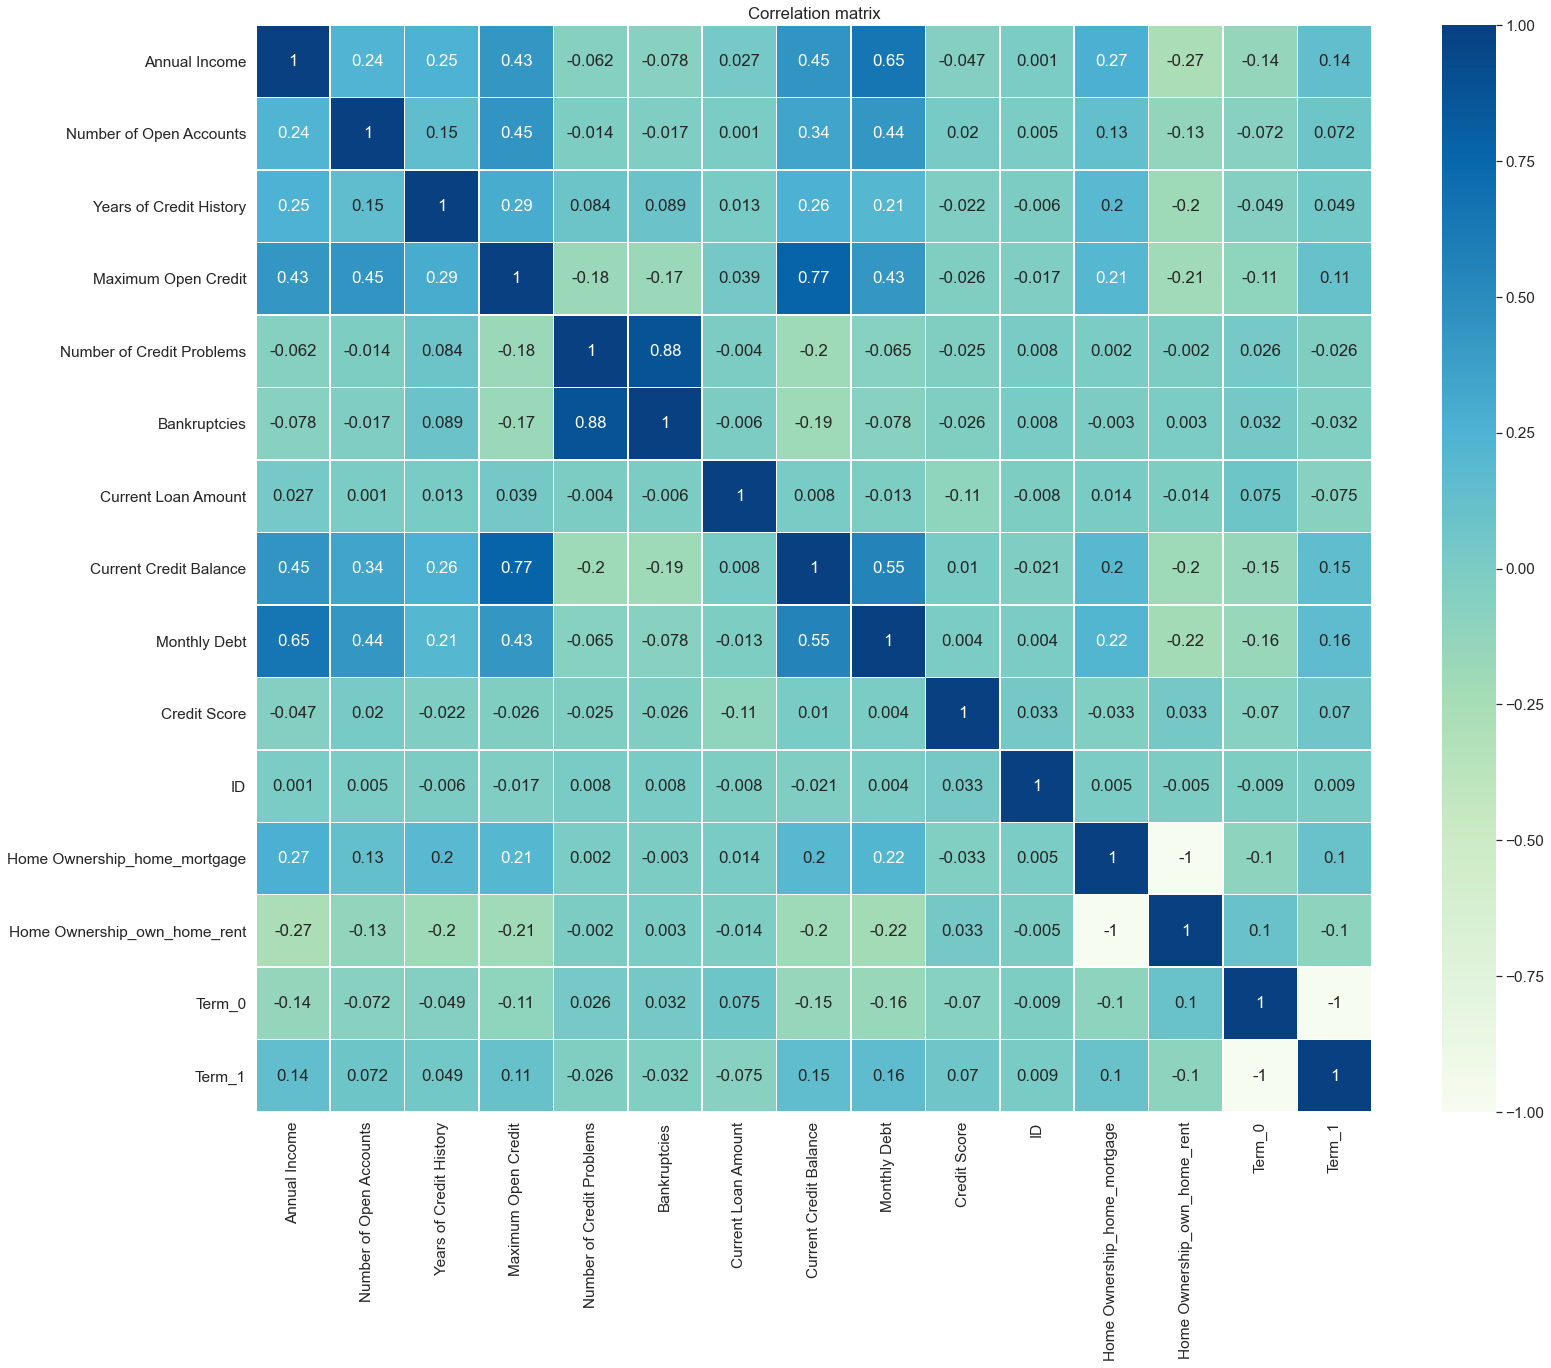

In [26]:
def deep_clean_data():
    
    
    # Построим новый справочник с объединенными категорями 'own_home' и 'rent'
    print('...построим новый справочник со стандартизированными категриальными значениями')
    corr_list = []
    corr_list.append(['Home Ownership', 'own_home', 'own_home_rent'])
    corr_list.append(['Home Ownership', 'rent', 'own_home_rent'])
    
    # Объединяем
    print('...скорректируем значения признаков в соответствии с новым справочником')
    c_train.cat_сorr_value(corr_list)
    c_test.cat_сorr_value(corr_list)
    
    # Удалим признаки "Years in current job" и "Purpose" как потенциально малоинфомативные
    print('...удалим признаки "Years in current job" и "Purpose" как потенциально малоинфомативные')
    c_train.drop_feature(["Years in current job", "Purpose"])
    c_test.drop_feature(["Years in current job", "Purpose"])
    
    #Удалим признаки из features_with_equel_math_ecpectation
#     feature = c_train.features_with_equel_math_ecpectation
#     try:
#         feature.pop(feature.index('ID'))
#     except ValueError:
#         print('признака ID нет в признаках на исключение из датасета')
#     print('...удалим признаки из features_with_equel_math_ecpectation')
#     c_train.drop_feature(feature)
#     c_test.drop_feature(feature)
    
    
    # Создадим dummy переменные в самом конце очистки
    print('...добавляем dummy переменные')
    c_train.create_dummy()
    c_test.create_dummy()
    
    
    
    # посмотрим на матрицу корреляций
    c_train.corr_matrix()

deep_clean_data()

### Выделение целевой переменной и групп признаков

In [27]:
TARGET_NAME = c_train.target_column
FEATURE_NAMES = c_train.X.columns.drop(TARGET_NAME).tolist()

### Отбор признаков<a class="anchor" id="feature_selection"></a>

In [28]:
NUM_FEATURE_NAMES = c_train.numeric_cols()
CAT_FEATURE_NAMES = c_train.non_numeric_cols()

Обзор числовых признаков

['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'ID', 'Home Ownership_home_mortgage', 'Home Ownership_own_home_rent', 'Term_0', 'Term_1'] 

Обзор не числовых признаков

['Home Ownership', 'Term'] 



In [29]:
df_train = c_train.X.copy()
df_test = c_test.X.copy()

### Приведение типов для модели CatBoost

In [30]:
def catbost_cast(df, cat_fetures):
    for colname in cat_fetures:
        df[colname] = pd.Categorical(df[colname])
    print(df[cat_fetures].dtypes)
    
catbost_cast(df_train, CAT_FEATURE_NAMES)
catbost_cast(df_test, CAT_FEATURE_NAMES)                 

Home Ownership    category
Term              category
dtype: object
Home Ownership    category
Term              category
dtype: object


### Нормализуем численные признаки на трейне и на тесте

In [31]:
scaler = StandardScaler() #создаем скалер

In [32]:
df_norm = df_train.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])
df_train = df_norm.copy() # нормализуем на трейне

In [33]:
df_norm = df_test.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])
df_test = df_norm.copy() # нормализуем на тесте

### Разбиение на train и test<a class="anchor" id="train_and_test"></a>

In [34]:
# X = df_train[NUM_FEATURE_NAMES+CAT_FEATURE_NAMES]
X = df_train[NUM_FEATURE_NAMES]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

### Балансировка целевой переменной<a class="anchor" id="target_balancing"></a>

In [35]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [36]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()
    

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [37]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
classes_distr = df_balanced[TARGET_NAME].value_counts()
rate_classes = round(classes_distr[0]/classes_distr[1],2)
print(f'количество объектов класса {classes_distr.index[0]} = {classes_distr[classes_distr.index[0]]}')
print(f'количество объектов класса {classes_distr.index[1]} = {classes_distr[classes_distr.index[1]]}')
print(f'Соотношение классов 0 к 1 = {rate_classes}')

количество объектов класса 0 = 3771
количество объектов класса 1 = 2958
Соотношение классов 0 к 1 = 1.27


In [38]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

In [39]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.92      0.82      3771
           1       0.85      0.58      0.69      2958

    accuracy                           0.77      6729
   macro avg       0.79      0.75      0.75      6729
weighted avg       0.78      0.77      0.76      6729

TEST

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1616
           1       0.72      0.58      0.65       634

    accuracy                           0.82      2250
   macro avg       0.79      0.75      0.76      2250
weighted avg       0.81      0.82      0.81      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1474  142
1                264  370


In [40]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.81      0.90      0.86      3771
           1       0.85      0.74      0.79      2958

    accuracy                           0.83      6729
   macro avg       0.83      0.82      0.82      6729
weighted avg       0.83      0.83      0.83      6729

TEST

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      1616
           1       0.57      0.56      0.57       634

    accuracy                           0.76      2250
   macro avg       0.70      0.70      0.70      2250
weighted avg       0.76      0.76      0.76      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1352  264
1                279  355


In [41]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3771
           1       1.00      1.00      1.00      2958

    accuracy                           1.00      6729
   macro avg       1.00      1.00      1.00      6729
weighted avg       1.00      1.00      1.00      6729

TEST

              precision    recall  f1-score   support

           0       0.84      0.91      0.88      1616
           1       0.72      0.56      0.63       634

    accuracy                           0.81      2250
   macro avg       0.78      0.74      0.75      2250
weighted avg       0.81      0.81      0.81      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1475  141
1                280  354


In [42]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3771
           1       0.99      0.93      0.96      2958

    accuracy                           0.97      6729
   macro avg       0.97      0.96      0.96      6729
weighted avg       0.97      0.97      0.96      6729

TEST

              precision    recall  f1-score   support

           0       0.84      0.91      0.88      1616
           1       0.72      0.56      0.63       634

    accuracy                           0.82      2250
   macro avg       0.78      0.74      0.75      2250
weighted avg       0.81      0.82      0.81      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1477  139
1                277  357


In [43]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      3771
           1       0.99      0.92      0.95      2958

    accuracy                           0.96      6729
   macro avg       0.96      0.96      0.96      6729
weighted avg       0.96      0.96      0.96      6729

TEST

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1616
           1       0.74      0.56      0.64       634

    accuracy                           0.82      2250
   macro avg       0.79      0.74      0.76      2250
weighted avg       0.81      0.82      0.81      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1489  127
1                279  355


### Подбор гиперпараметров

In [44]:
# Найдем реальное соотношение классов в исходном датасете
classes_distr = df_train[TARGET_NAME].value_counts()
rate_classes = round(classes_distr[0]/classes_distr[1],2)
print(f'количество объектов класса {classes_distr.index[0]} = {classes_distr[classes_distr.index[0]]}')
print(f'количество объектов класса {classes_distr.index[1]} = {classes_distr[classes_distr.index[1]]}')
print(f'Соотношение классов 0 к 1 = {rate_classes}')

количество объектов класса 0 = 5387
количество объектов класса 1 = 2113
Соотношение классов 0 к 1 = 2.55


In [45]:
model_catb = catb.CatBoostClassifier(class_weights=[1, rate_classes], silent=True, random_state=21)

In [46]:
params = {'n_estimators':[50, 100, 200, 500],
          'max_depth':[2, 3, 4],
         'l2_leaf_reg':[1, 3, 7, 10],
         'cat_features':[CAT_FEATURE_NAMES, []]}
#cat_features=CAT_FEATURE_NAMES

In [47]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [48]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_iter = 20)
rs.fit(X, y)

CPU times: user 1min 34s, sys: 4.62 s, total: 1min 38s
Wall time: 10.1 s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x1379dd670>,
                   n_iter=20,
                   param_distributions={'cat_features': [['Home Ownership',
                                                          'Term'],
                                                         []],
                                        'l2_leaf_reg': [1, 3, 7, 10],
                                        'max_depth': [2, 3, 4],
                                        'n_estimators': [50, 100, 200, 500]},
                   scoring='f1')

In [49]:
rs.best_params_
n_estimators = rs.best_params_['n_estimators']
max_depth = rs.best_params_['max_depth']
l2_leaf_reg = rs.best_params_['l2_leaf_reg']
cat_features = rs.best_params_['cat_features']
print(f'n_estimators = {n_estimators}')
print(f'max_depth = {max_depth}')
print(f'l2_leaf_reg = {l2_leaf_reg}')
print(f'cat_features = {cat_features}')

n_estimators = 200
max_depth = 4
l2_leaf_reg = 1
cat_features = []


### Обучение и оценка финальной модели

In [50]:
X_train.columns

Index(['Annual Income', 'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'ID', 'Home Ownership_home_mortgage',
       'Home Ownership_own_home_rent', 'Term_0', 'Term_1'],
      dtype='object')

In [51]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=n_estimators, max_depth=max_depth, l2_leaf_reg=l2_leaf_reg,
                                      cat_features=cat_features,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.95      0.84      3771
           1       0.91      0.59      0.71      2958

    accuracy                           0.79      6729
   macro avg       0.83      0.77      0.78      6729
weighted avg       0.82      0.79      0.78      6729

TEST

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      1616
           1       0.81      0.55      0.66       634

    accuracy                           0.84      2250
   macro avg       0.83      0.75      0.77      2250
weighted avg       0.83      0.84      0.83      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1534   82
1                285  349
CPU times: user 8.08 s, sys: 341 ms, total: 8.43 s
Wall time: 913 ms


### Подбор оптимального размера выборки, кривая обучения

In [52]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [53]:
final_model_param = catb.CatBoostClassifier(n_estimators=n_estimators, max_depth=max_depth, l2_leaf_reg = l2_leaf_reg,
                                      class_weights=[1, rate_classes],
                                      silent=True, random_state=21)

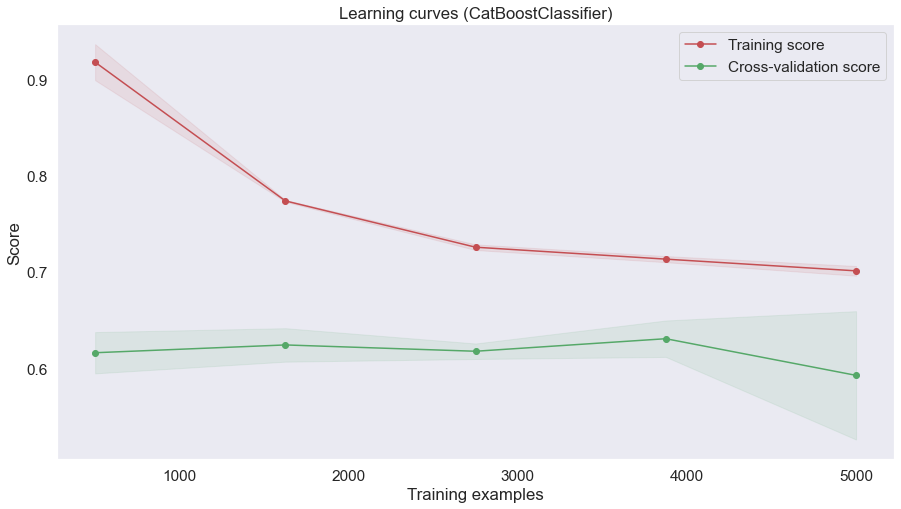

In [54]:
show_learning_curve_plot(final_model_param, X, y)

### Выбор порога вероятности для определения класса<a class="anchor" id="threshold_calibration"></a>

In [55]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

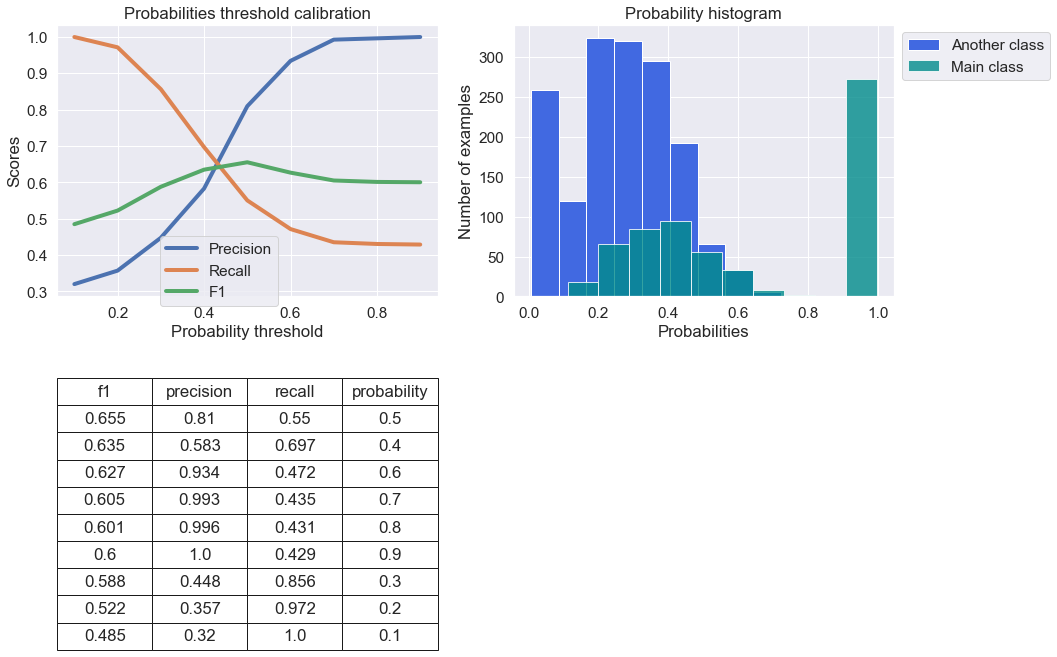

In [56]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

In [57]:
# определение списка лучших признаков по модели
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        get_top = 20
        return feature_importances['feature'][:get_top].tolist()

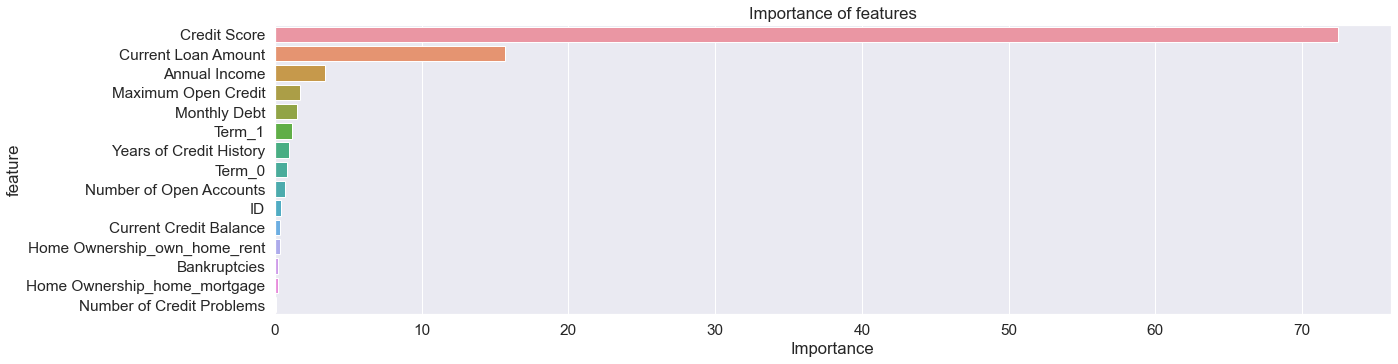

['Credit Score', 'Current Loan Amount', 'Annual Income', 'Maximum Open Credit', 'Monthly Debt', 'Term_1', 'Years of Credit History', 'Term_0', 'Number of Open Accounts', 'ID', 'Current Credit Balance', 'Home Ownership_own_home_rent', 'Bankruptcies', 'Home Ownership_home_mortgage', 'Number of Credit Problems']


In [58]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=10)
print(important_features_top)

### Финальная модель<a class="anchor" id="final_model"></a>

In [59]:
# # на всем пространстве признаков
# final_model = catb.CatBoostClassifier(n_estimators=n_estimators, max_depth=max_depth, l2_leaf_reg=l2_leaf_reg,
#                                       cat_features=cat_features,
#                                       silent=True, random_state=21)
# final_model.fit(X_train, y_train)

# y_train_pred = final_model.predict(X_train)
# y_test_pred = final_model.predict(X_test)
# y_test_pred_probs = final_model.predict_proba(X_test)

# get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
# final_model_all_features = final_model

In [60]:
# на важных признаках и вручную подобранными гиперпараметрами
final_model = catb.CatBoostClassifier(n_estimators=n_estimators, max_depth=max_depth, l2_leaf_reg=l2_leaf_reg,
                                      cat_features=cat_features,
                                      silent=True, random_state=21)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
final_model_importante_features = final_model

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.95      0.84      3771
           1       0.91      0.59      0.72      2958

    accuracy                           0.79      6729
   macro avg       0.83      0.77      0.78      6729
weighted avg       0.82      0.79      0.78      6729

TEST

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      1616
           1       0.80      0.55      0.65       634

    accuracy                           0.83      2250
   macro avg       0.82      0.75      0.77      2250
weighted avg       0.83      0.83      0.82      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1528   88
1                285  349


### Сохранение финальной модели

In [61]:
 # Сохраним датасет в файл
df_train.to_csv(PREP_TRAIN_DATASET_PATH, index=False, encoding='utf-8')
df_test.to_csv(PREP_TEST_DATASET_PATH, index=False, encoding='utf-8')

### Предсказываем и выгружаем в файл

In [62]:
df_test[TARGET_NAME] = final_model.predict(df_test[important_features_top])
df_test['ID'] = df_test.index.tolist()
df_test[['ID',TARGET_NAME]].to_csv('SGSolovyev_predictions.csv', index=False)

### В рамках данной курсовой задание выполнено с достижением F1 = 0.65 по целевой метрике на трейне